# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Quick Links

<ol>
    <li><a href=#effect_table>Effect Alleles Table</a></li>
    <li><a href=#effect_viz>Effect Alleles Visual</a></li>
    <li><a href=#noneffect_table>Non-Effect Alleles Table</a></li>
    <li><a href=#noneffect_viz>Non-Effect Alleles Visual</a></li>
</ol>

# Cluster 22

In [2]:
cluster = '22'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 550
Num noneffect sequences: 550


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    #allele_diff.append(effect_center[-1] - noneffect_center[-1])
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['allele_ratio'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)

## Find Effect Alleles that Break Accessibility <a name='effect_table' />

In [5]:
neg_snps = snps.loc[snps['allele_ratio'] <= 1]
neg_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end         rsid effect noneffect ref  \
376  chr19   45001090   45001091   rs35577563      C         G   C   
387  chr19   45326535   45326536     rs344791      C         G   G   
504   chr4   89836583   89836584    rs2619361      C         A   C   
421   chr2  127128581  127128582   rs13025717      T         C   C   
26   chr11   47373688   47373689    rs7940536      A         G   G   
181  chr17   45883677   45883678   rs62055539      G         A   A   
234  chr17   45977229   45977230   rs17572495      T         G   T   
162  chr17   45852871   45852872   rs79589869      C         A   C   
71   chr15   58758182   58758183    rs2250583      C         T   C   
505   chr4   89837895   89837896    rs2619363    NAN       NAN   G   
328  chr19   18462023   18462024    rs8103622      T         C   C   
518   chr6   27772520   27772521     rs760587      C         A   C   
435   chr3   49007333   49007334    rs6781790      T         C   C   
61   chr14   67516841   67516842    rs7140470      T         C   T   
90   chr16   31117346   31117347   rs12716982      C         A   C   
199  chr17   45914204   45914205  rs141801658      I         D   G   
195  chr17   45896285   45896286   rs62056780      T         C   C   
40   chr11   86067881   86067882     rs544458      C         T   C   
175  chr17   45882974   45882975   rs56127309      G         A   G   
267  chr17   46118786   46118787    rs1468241      G         A   A   
100  chr17    4858739    4858740   rs16954223      A         C   A   
215  chr17   45941121   45941122  17_45941122      T         C   .   
260  chr17   46061823   46061824    rs2316952      G         C   G   
304  chr17   78426790   78426791   rs72914885      C         A   A   
185  chr17   45894418   45894419   rs11575895      G         A   A   
163  chr17   45861027   45861028   rs74872829      G         A   A   
139  chr17   45825630   45825631    rs1396862      A         G   G   
276  chr17   46143983   46143984    rs2532307      A         G   G   
107  chr17    4901871    4901872   rs79436576      T         C   C   
68   chr14   74903419   74903420      rs13391      T         C   C   
..     ...        ...        ...          ...    ...       ...  ..   
392   chr2   95232018   95232019    rs6725821      T         C   T   
136  chr17   45825475   45825476   rs41280116      T         C   C   
442   chr3   52339932   52339933  rs149814394      G         A   G   
455   chr4     959405     959406   rs34931738      I         D  TC   
112  chr17    4909107    4909108   rs16954243      A         T   A   
287  chr17   62065536   62065537  rs118039704      G         A   G   
462   chr4   18021068   18021069    rs7659195      T         C   T   
69   chr15   58691225   58691226    rs7161889      C         G   G   
47   chr11   86145144   86145145    rs7110631      C         G   C   
502   chr4   89836353   89836354    rs1372520      T         C   T   
434   chr3   48948965   48948966   rs13315711      T         A   A   
161  chr17   45849625   45849626   rs56269136      T         C   C   
417   chr2  127107527  127107528  2_127107528    NAN       NAN   .   
238  chr17   45978280   45978281     rs754512      A         T   A   
178  chr17   45883544   45883545   rs56180212      G         A   A   
389   chr2   95071933   95071934    rs4854244      C         A   A   
114  chr17    5111493    5111494   rs56229705      A         G   G   
407   chr2  127081957  127081958   rs11690153      C         T   T   
356  chr19   44913483   44913484     rs438811    NAN       NAN   C   
110  chr17    4903854    4903855   rs74574706    NAN       NAN   C   
247  chr17   46013279   46013280   rs12150170      G         A   A   
381  chr19   45045876   45045877  rs112481437      A         G   G   
273  chr17   46122711   46122712  rs112560196      T         A   A   
226  chr17   45949128   45949129   rs74531363      G         A   A   
224  chr17   45949111   45949112   rs78556223      G         A   A   
67   chr14   7471

## Visualize Top Effect Alleles <a name='effect_viz' />

RSID: rs35577563   ||    chr19 : 45001090 - 45001091   ||    Locus: 376   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  3.70E-12
Alzheimers_Kunkle_2019 		  4.76E-09
Alzheimers_Lambert_2013 	  2.68E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.4431   ||   Center / 200bp : 0.5772
Noneffect Sequence : AGAGCCCTGGCAACCTCTCG


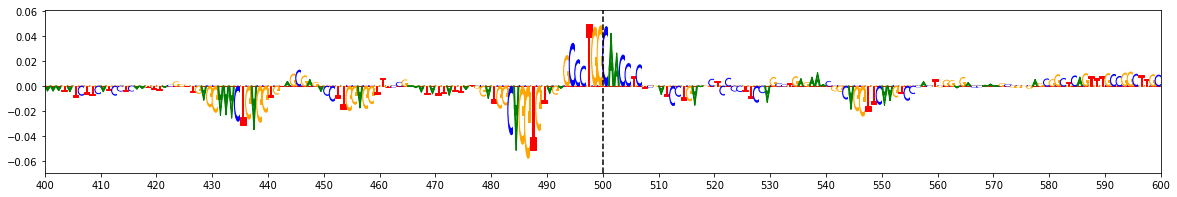

Effect Allele : C   ||   Explain Score : 0.1962   ||   Center / 200bp : 0.3775
Effect Sequence : AGAGCCCTGCCAACCTCTCG


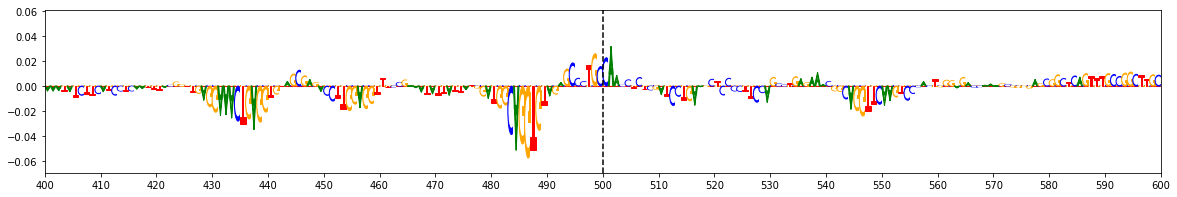

Allele Ratio : 0.4428   ||   Allele Difference : -0.2546  ||  ISM Score : -0.3972  ||  deltaSVM Score : -2.2774


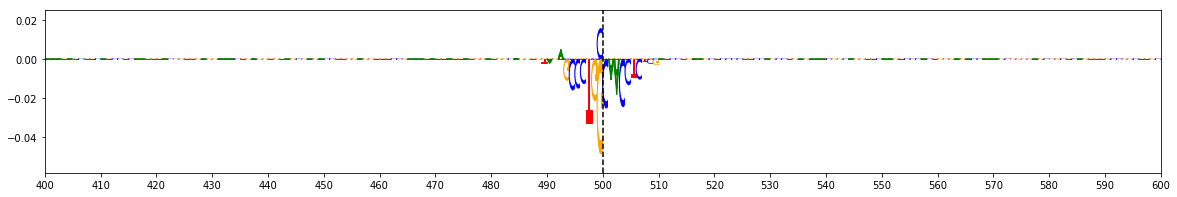


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs344791   ||    chr19 : 45326535 - 45326536   ||    Locus: 387   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.22E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.3899   ||   Center / 200bp : 0.5364
Noneffect Sequence : CTCAAGACCGCCTCCACTGT


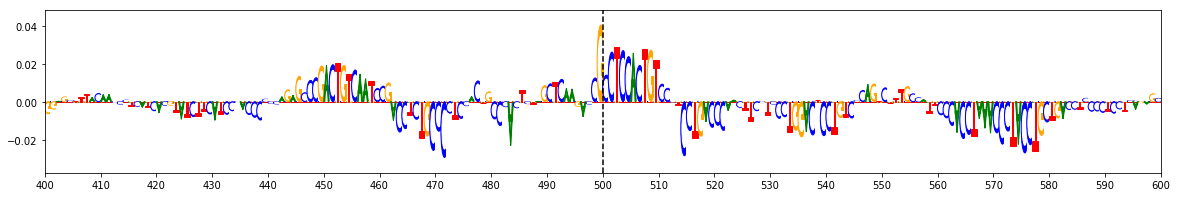

Effect Allele : C   ||   Explain Score : 0.1654   ||   Center / 200bp : 0.3316
Effect Sequence : CTCAAGACCCCCTCCACTGT


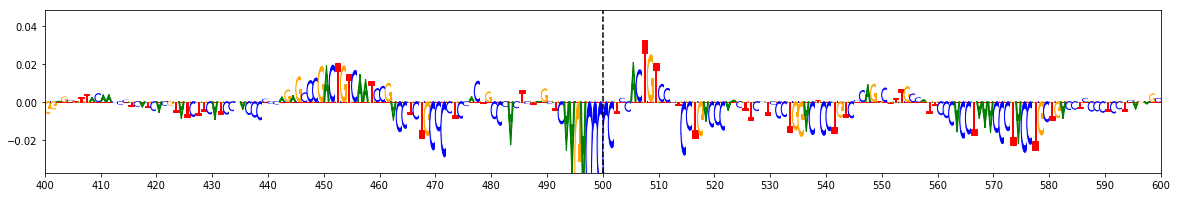

Allele Ratio : 0.4241   ||   Allele Difference : -0.6766  ||  ISM Score : -1.0781  ||  deltaSVM Score : -6.212


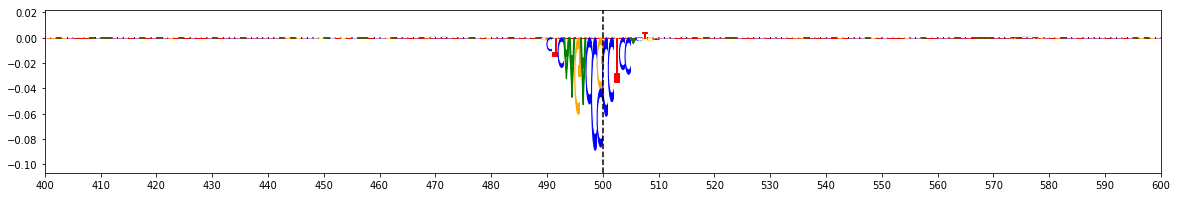


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619361   ||    chr4 : 89836583 - 89836584   ||    Locus: 504   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  2.97E-07
23andme_PD_hg38 		  1.36E-08

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.2751   ||   Center / 200bp : 0.2717
Noneffect Sequence : GTCTCTTTCATTAGGCTCCC


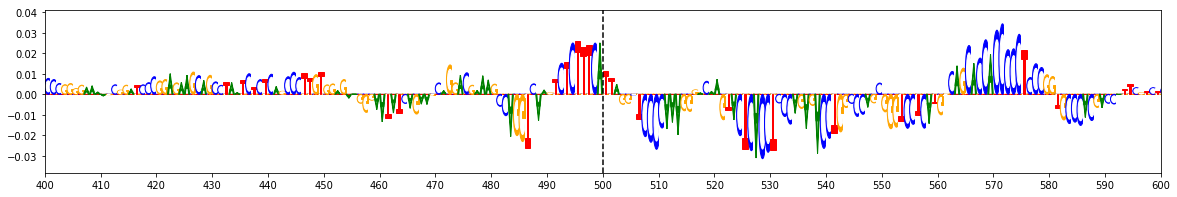

Effect Allele : C   ||   Explain Score : 0.0646   ||   Center / 200bp : 0.0804
Effect Sequence : GTCTCTTTCCTTAGGCTCCC


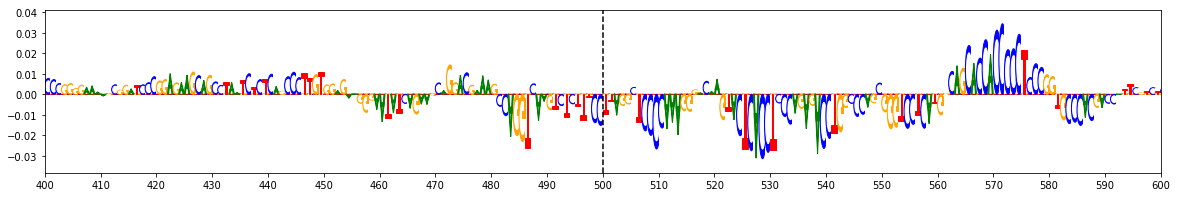

Allele Ratio : 0.2347   ||   Allele Difference : -0.3165  ||  ISM Score : -0.4948  ||  deltaSVM Score : -2.8891


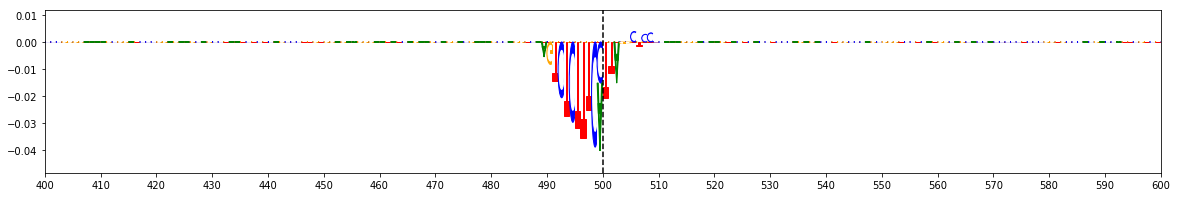


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs13025717   ||    chr2 : 127128581 - 127128582   ||    Locus: 421   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  9.13E-17
Alzheimers_Kunkle_2019 		  2.98E-15
Alzheimers_Lambert_2013 	  7.94E-13

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.1487   ||   Center / 200bp : 0.5689
Noneffect Sequence : CAGAAGCCCCGCCCAATGAG


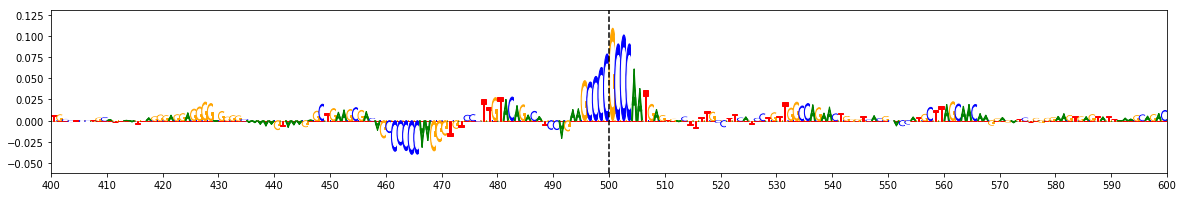

Effect Allele : T   ||   Explain Score : 0.593   ||   Center / 200bp : 0.4053
Effect Sequence : CAGAAGCCCTGCCCAATGAG


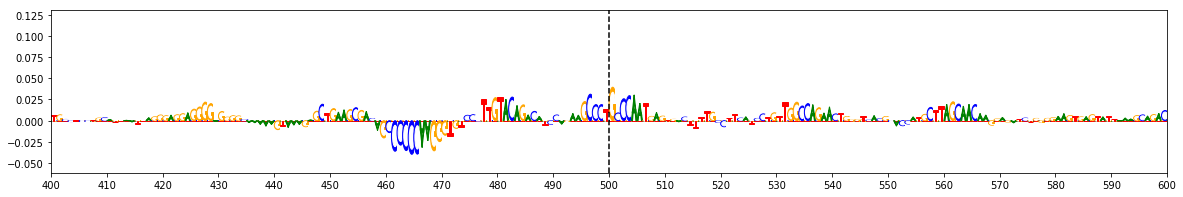

Allele Ratio : 0.5162   ||   Allele Difference : -0.5113  ||  ISM Score : -0.7969  ||  deltaSVM Score : -4.4653


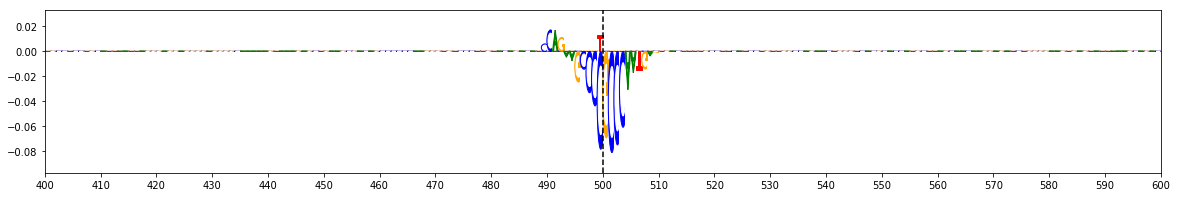


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7940536   ||    chr11 : 47373688 - 47373689   ||    Locus: 26   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  2.79E-10

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.0516   ||   Center / 200bp : 0.6534
Noneffect Sequence : GCCCTGATTGGCAGTGATTA


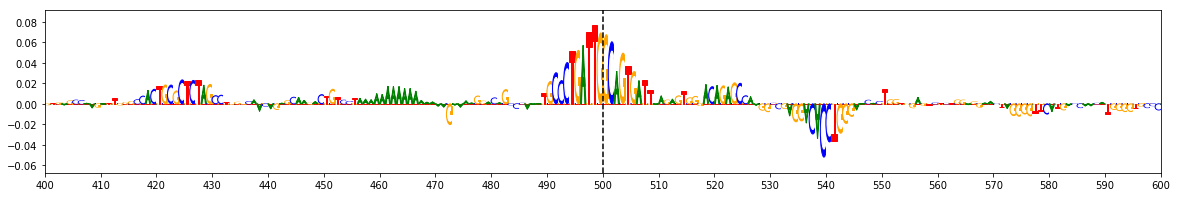

Effect Allele : A   ||   Explain Score : 0.6469   ||   Center / 200bp : 0.5371
Effect Sequence : GCCCTGATTAGCAGTGATTA


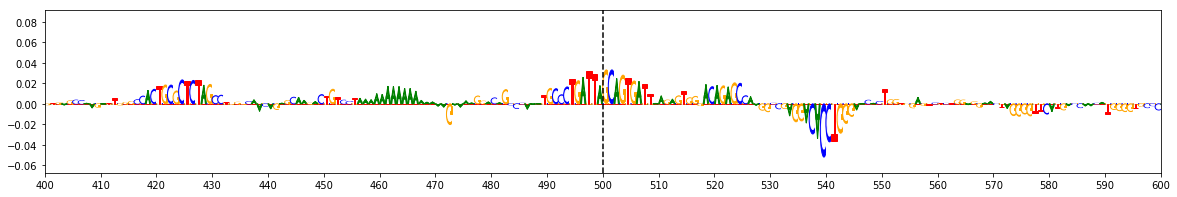

Allele Ratio : 0.6151   ||   Allele Difference : -0.404  ||  ISM Score : -0.7172  ||  deltaSVM Score : -4.1342


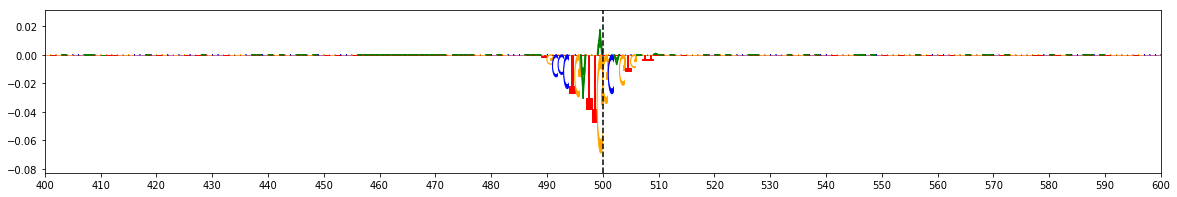


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62055539   ||    chr17 : 45883677 - 45883678   ||    Locus: 181   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.89E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.8591   ||   Center / 200bp : 0.6756
Noneffect Sequence : CCACCCTCTAGAGTGTGTGT


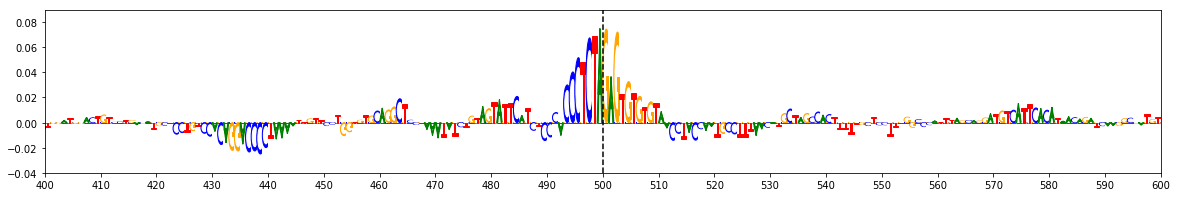

Effect Allele : G   ||   Explain Score : 0.5617   ||   Center / 200bp : 0.5743
Effect Sequence : CCACCCTCTGGAGTGTGTGT


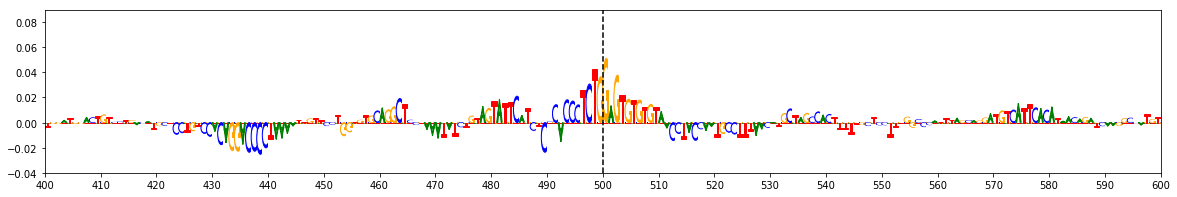

Allele Ratio : 0.6539   ||   Allele Difference : -0.3014  ||  ISM Score : -0.4537  ||  deltaSVM Score : -2.7375


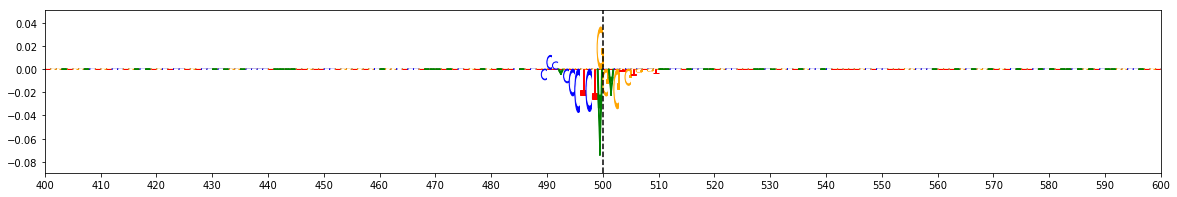


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17572495   ||    chr17 : 45977229 - 45977230   ||    Locus: 234   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.29E-22
Parkinsons_Pankratz_2012 	  3.43E-10

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.6393   ||   Center / 200bp : 0.302
Noneffect Sequence : CACATGGCTGCCAGGAAACT


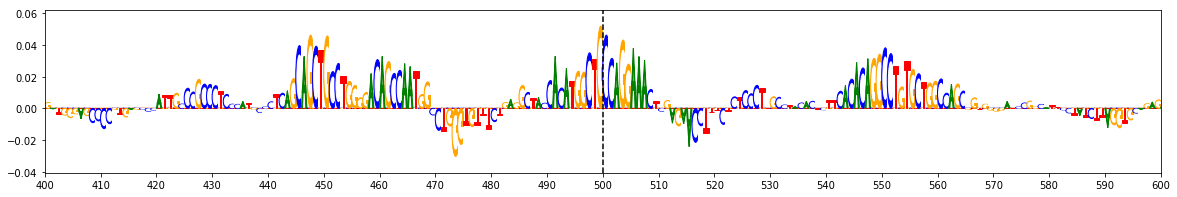

Effect Allele : T   ||   Explain Score : 0.1873   ||   Center / 200bp : 0.1125
Effect Sequence : CACATGGCTTCCAGGAAACT


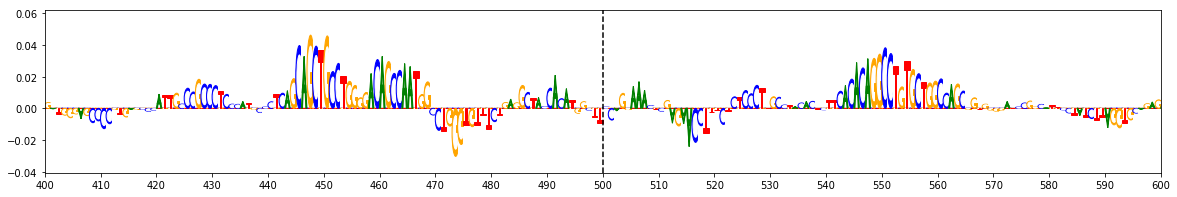

Allele Ratio : 0.2931   ||   Allele Difference : -0.4815  ||  ISM Score : -0.7566  ||  deltaSVM Score : -4.3643


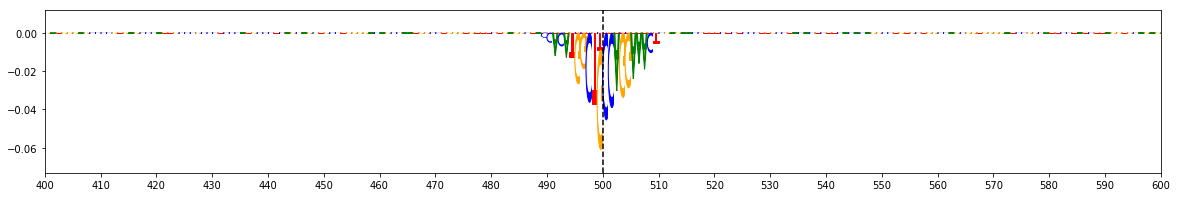


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79589869   ||    chr17 : 45852871 - 45852872   ||    Locus: 162   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.11E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 3.9964   ||   Center / 200bp : 0.9179
Noneffect Sequence : TTGAATGCTACTGTGCTGCC


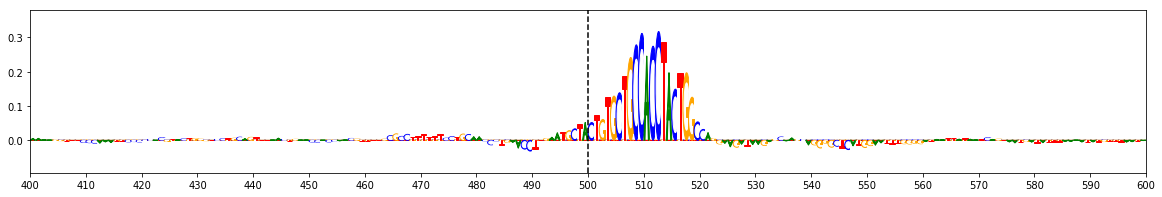

Effect Allele : C   ||   Explain Score : 3.593   ||   Center / 200bp : 0.9095
Effect Sequence : TTGAATGCTCCTGTGCTGCC


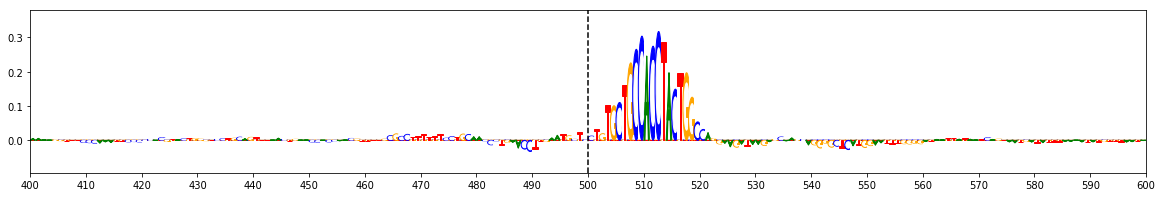

Allele Ratio : 0.899   ||   Allele Difference : -0.4075  ||  ISM Score : -0.6383  ||  deltaSVM Score : -3.679


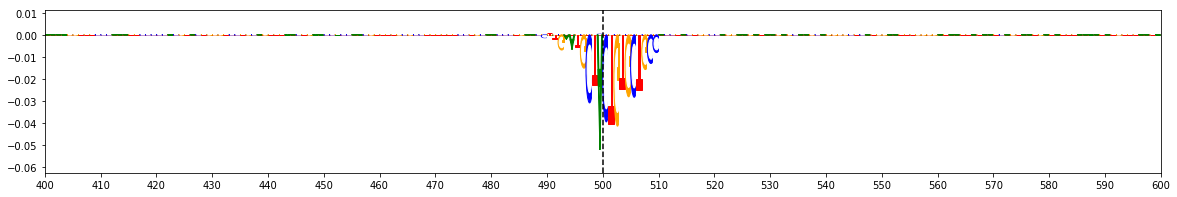


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2250583   ||    chr15 : 58758182 - 58758183   ||    Locus: 71   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  8.26E-09

Coloc:  False

Noneffect Allele : T   ||   Explain Score : 0.7646   ||   Center / 200bp : 0.7474
Noneffect Sequence : ATGAGCCATTGAGCCTGGCC


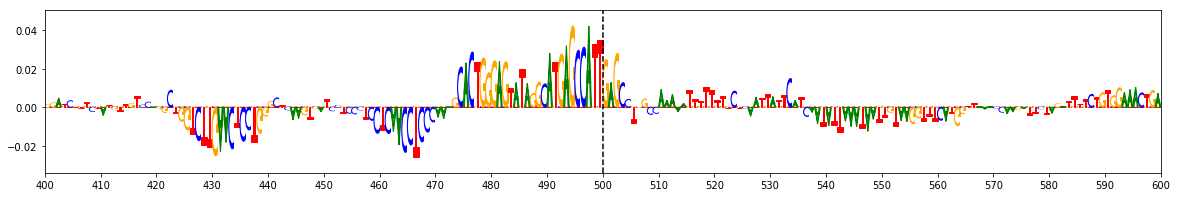

Effect Allele : C   ||   Explain Score : 0.5909   ||   Center / 200bp : 0.6957
Effect Sequence : ATGAGCCATCGAGCCTGGCC


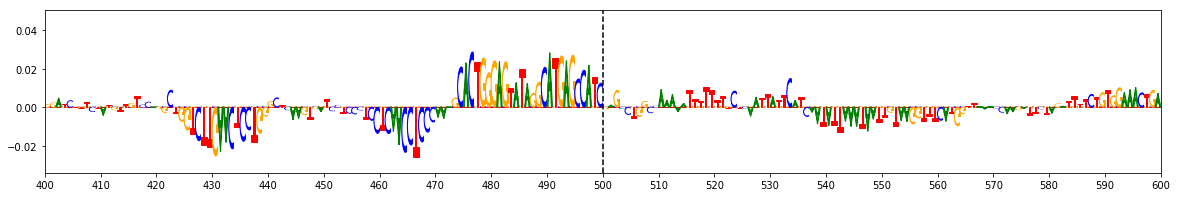

Allele Ratio : 0.7728   ||   Allele Difference : -0.1771  ||  ISM Score : -0.2856  ||  deltaSVM Score : -1.672


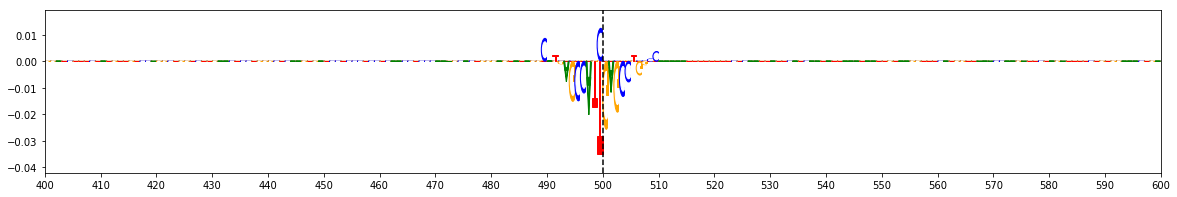


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619363   ||    chr4 : 89837895 - 89837896   ||    Locus: 505   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  1.43E-08

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 1.0705   ||   Center / 200bp : 0.5303
Noneffect Sequence : CCAATCAGCGCCTGCCAGAC


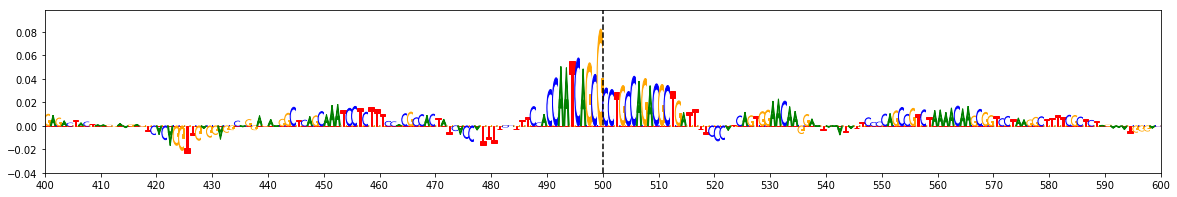

Effect Allele : NAN   ||   Explain Score : 0.5871   ||   Center / 200bp : 0.3806
Effect Sequence : CCAATCAGCCCCTGCCAGAC


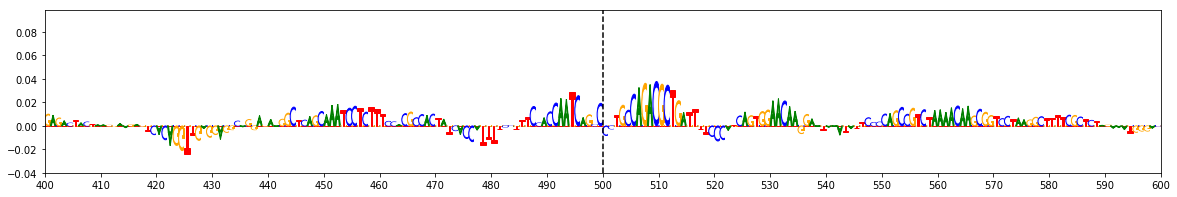

Allele Ratio : 0.5485   ||   Allele Difference : -0.4951  ||  ISM Score : -0.75  ||  deltaSVM Score : -4.5478


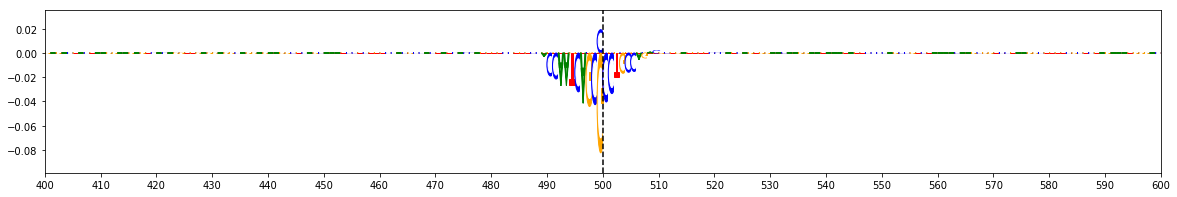


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs8103622   ||    chr19 : 18462023 - 18462024   ||    Locus: 328   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  7.31E-02
Alzheimers_Kunkle_2019 		  1.28E-05
Alzheimers_Lambert_2013 	  3.29E-05

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 2.4694   ||   Center / 200bp : 0.6994
Noneffect Sequence : GACCAAGAGCGCCACCTGCT


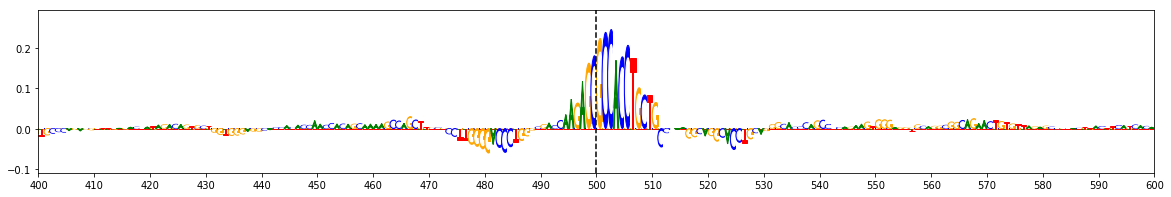

Effect Allele : T   ||   Explain Score : 1.8168   ||   Center / 200bp : 0.6314
Effect Sequence : GACCAAGAGTGCCACCTGCT


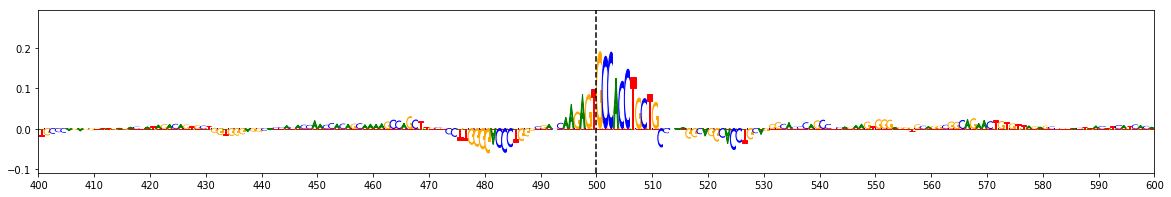

Allele Ratio : 0.7357   ||   Allele Difference : -0.6547  ||  ISM Score : -1.0762  ||  deltaSVM Score : -6.1666


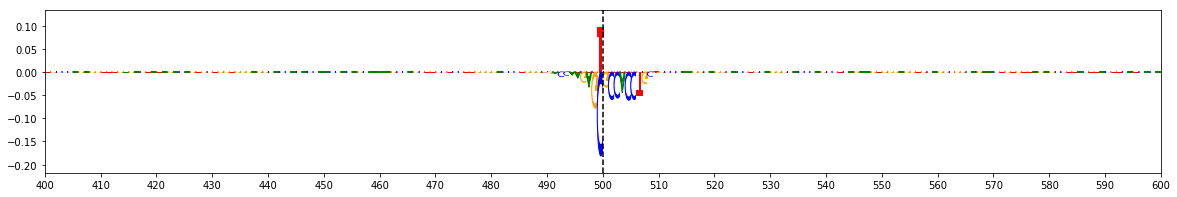


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs760587   ||    chr6 : 27772520 - 27772521   ||    Locus: 518   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  6.44E-06

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 1.3838   ||   Center / 200bp : 0.5623
Noneffect Sequence : GAGCAGCAAACAAAGGCTAA


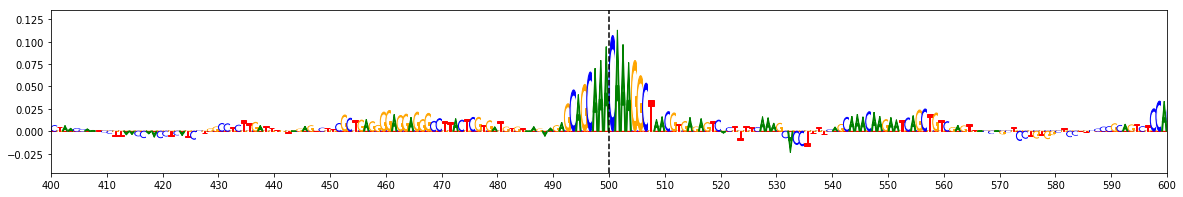

Effect Allele : C   ||   Explain Score : 0.8567   ||   Center / 200bp : 0.4421
Effect Sequence : GAGCAGCAACCAAAGGCTAA


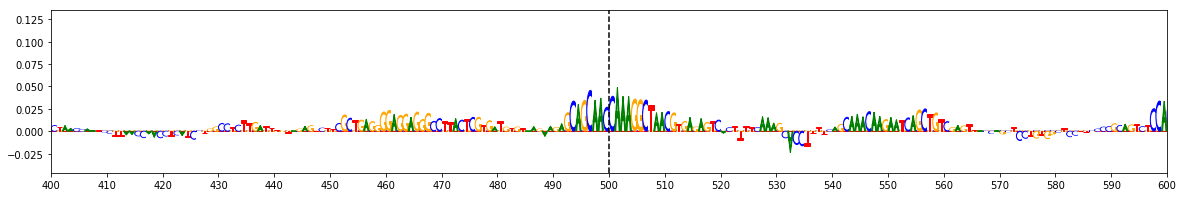

Allele Ratio : 0.6191   ||   Allele Difference : -0.5271  ||  ISM Score : -0.8298  ||  deltaSVM Score : -4.7093


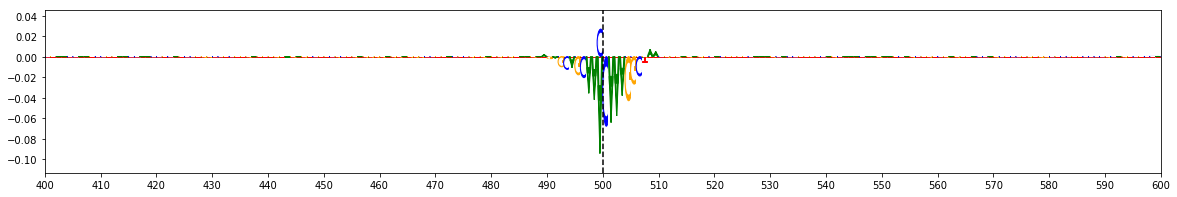


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6781790   ||    chr3 : 49007333 - 49007334   ||    Locus: 435   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  2.35E-03
Nalls_23andMe 		  2.35E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.2866   ||   Center / 200bp : 0.461
Noneffect Sequence : AGCTGAGGGCGCTGTTGATG


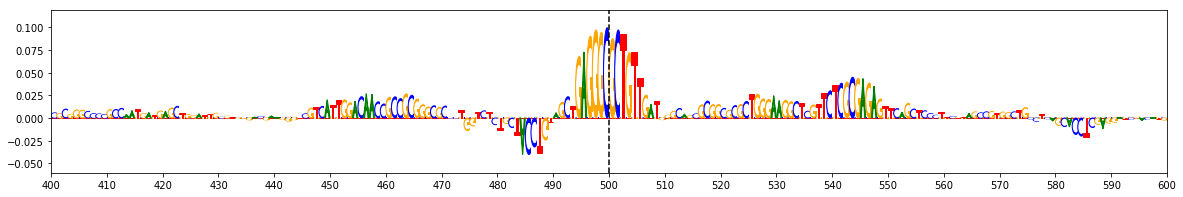

Effect Allele : T   ||   Explain Score : 0.6616   ||   Center / 200bp : 0.3052
Effect Sequence : AGCTGAGGGTGCTGTTGATG


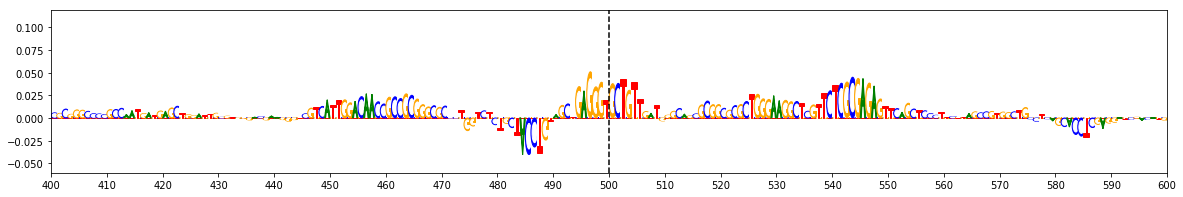

Allele Ratio : 0.5142   ||   Allele Difference : -0.6249  ||  ISM Score : -0.9845  ||  deltaSVM Score : -5.6603


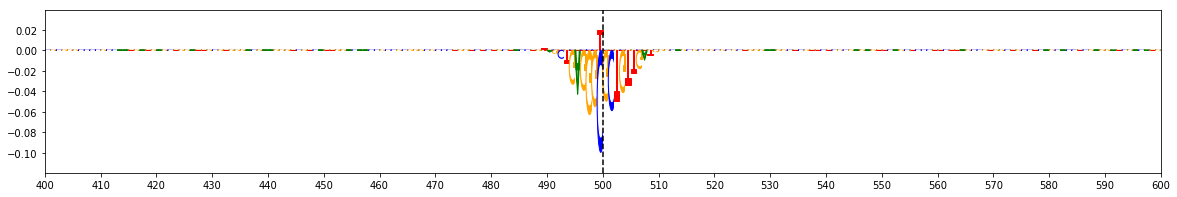


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7140470   ||    chr14 : 67516841 - 67516842   ||    Locus: 61   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  4.51E-01

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.6597   ||   Center / 200bp : 0.6513
Noneffect Sequence : GGAGTCATGCTGGGTTCCTC


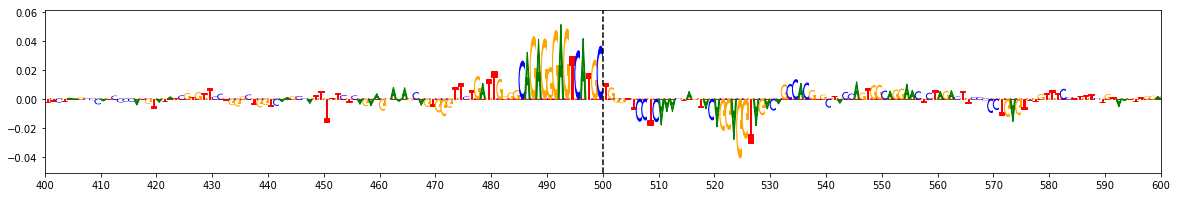

Effect Allele : T   ||   Explain Score : 0.4804   ||   Center / 200bp : 0.5764
Effect Sequence : GGAGTCATGTTGGGTTCCTC


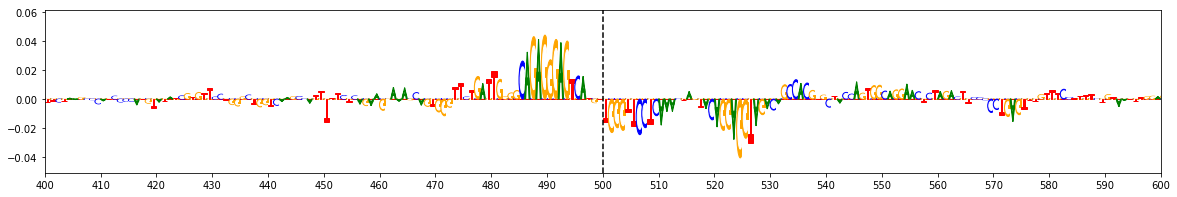

Allele Ratio : 0.7283   ||   Allele Difference : -0.2891  ||  ISM Score : -0.4509  ||  deltaSVM Score : -2.5769


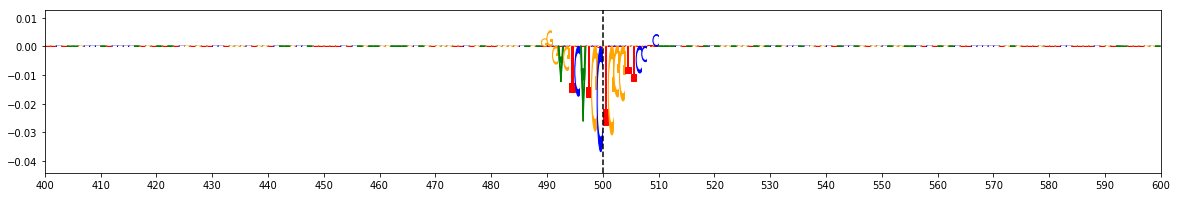


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12716982   ||    chr16 : 31117346 - 31117347   ||    Locus: 90   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  3.40E-02

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.7231   ||   Center / 200bp : 0.5693
Noneffect Sequence : CAGCCTGGGAGACAGAGCAT


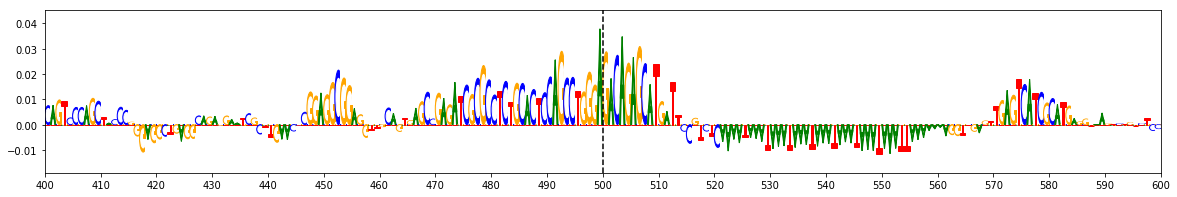

Effect Allele : C   ||   Explain Score : 0.4693   ||   Center / 200bp : 0.4618
Effect Sequence : CAGCCTGGGCGACAGAGCAT


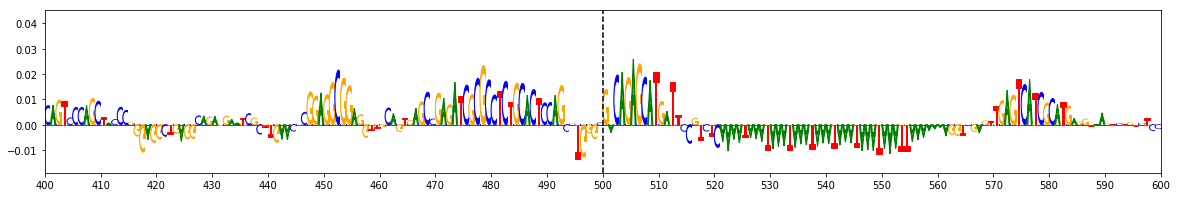

Allele Ratio : 0.649   ||   Allele Difference : -0.2944  ||  ISM Score : -0.5757  ||  deltaSVM Score : -3.348


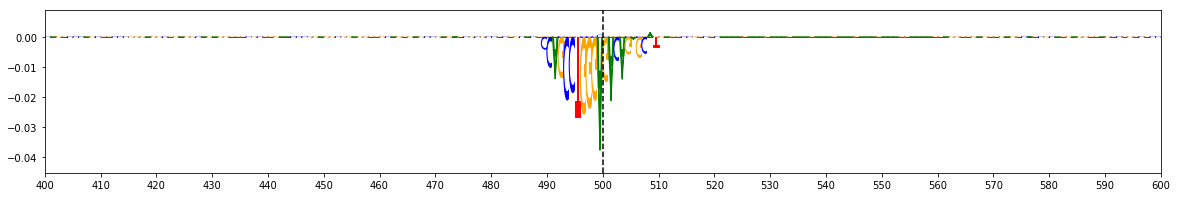


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs141801658   ||    chr17 : 45914204 - 45914205   ||    Locus: 199   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  4.43E-12

Coloc:  True

Noneffect Allele : D   ||   Explain Score : 0.7746   ||   Center / 200bp : 0.4755
Noneffect Sequence : CAGGGATCTGAGGGTGTGGG


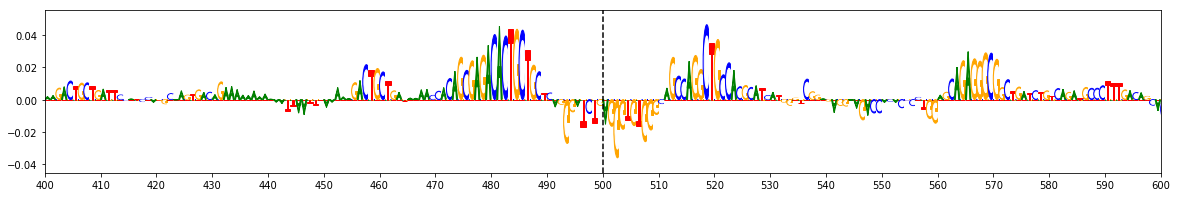

Effect Allele : I   ||   Explain Score : 0.4321   ||   Center / 200bp : 0.3258
Effect Sequence : CAGGGATCTGAGGGTGTGGG


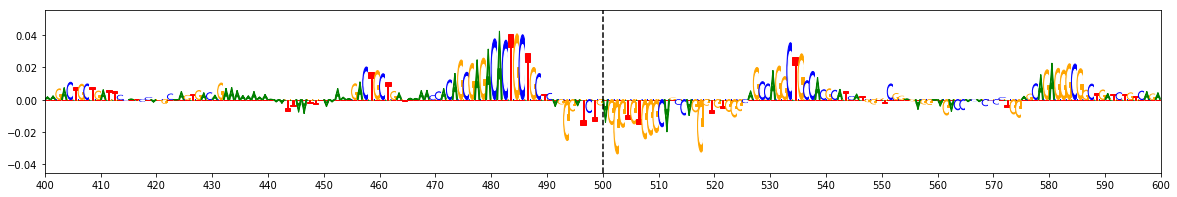

Allele Ratio : 0.5579   ||   Allele Difference : -0.4839  ||  ISM Score : -0.5343  ||  deltaSVM Score : -3.659


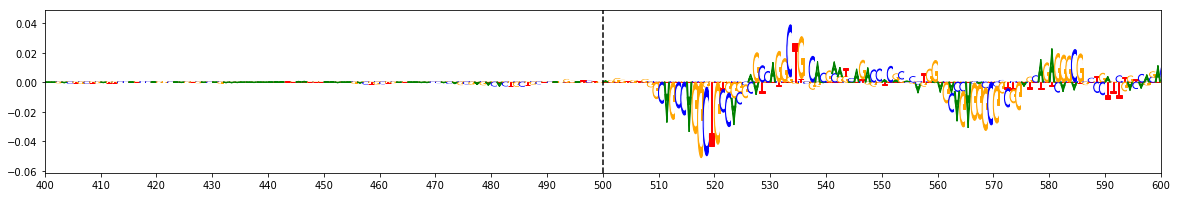


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62056780   ||    chr17 : 45896285 - 45896286   ||    Locus: 195   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.9285   ||   Center / 200bp : 0.589
Noneffect Sequence : GAGGGATCTCGCCCCTCCCT


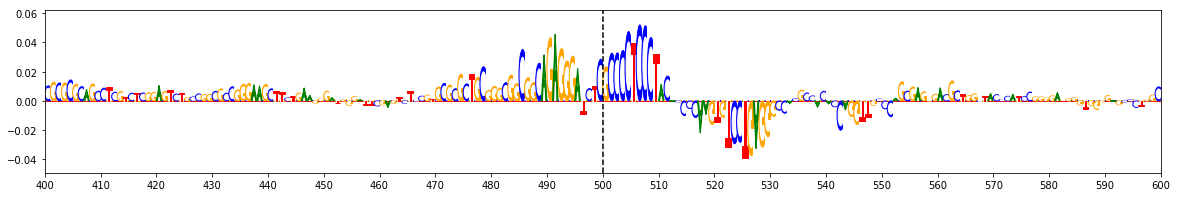

Effect Allele : T   ||   Explain Score : 0.6428   ||   Center / 200bp : 0.4979
Effect Sequence : GAGGGATCTTGCCCCTCCCT


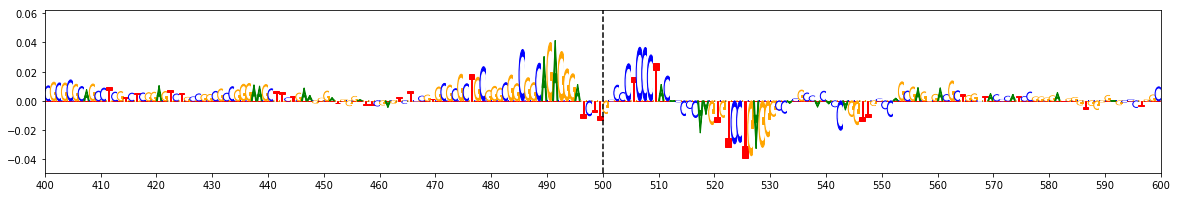

Allele Ratio : 0.6922   ||   Allele Difference : -0.3277  ||  ISM Score : -0.5166  ||  deltaSVM Score : -2.9808


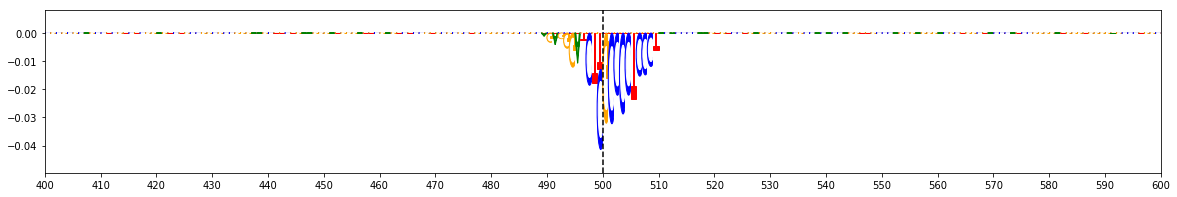


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs544458   ||    chr11 : 86067881 - 86067882   ||    Locus: 40   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.70E-11

Coloc:  False

Noneffect Allele : T   ||   Explain Score : 1.4623   ||   Center / 200bp : 0.6422
Noneffect Sequence : ACAACACAATGATTAAATTC


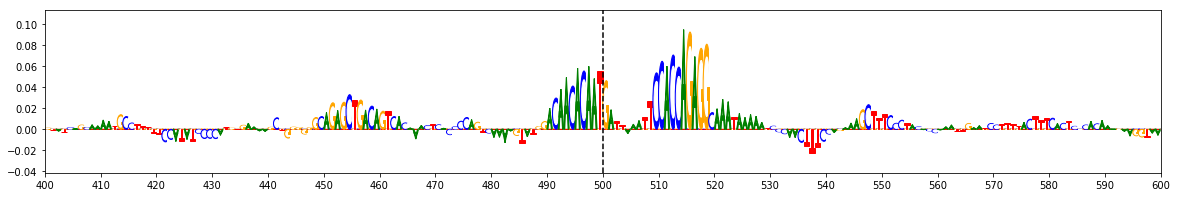

Effect Allele : C   ||   Explain Score : 1.1133   ||   Center / 200bp : 0.5774
Effect Sequence : ACAACACAACGATTAAATTC


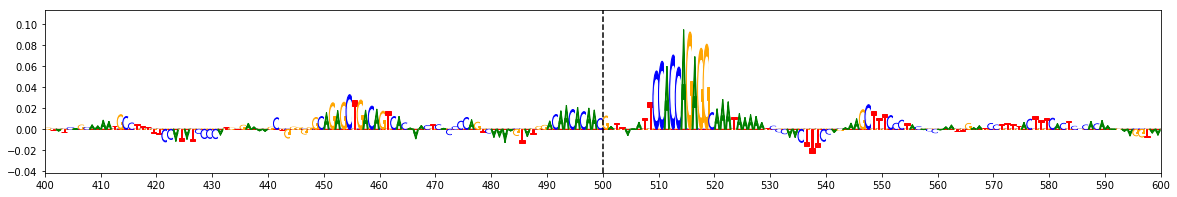

Allele Ratio : 0.7614   ||   Allele Difference : -0.3508  ||  ISM Score : -0.5492  ||  deltaSVM Score : -3.2119


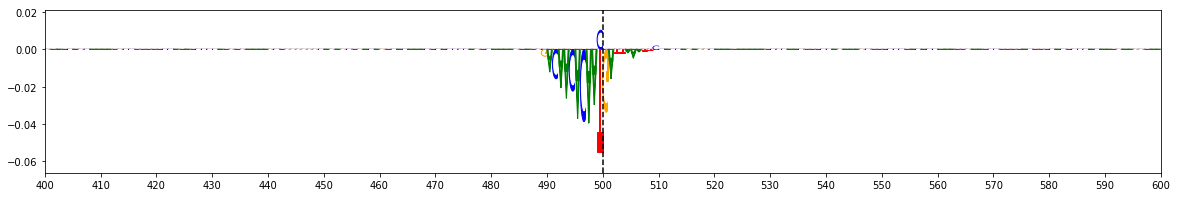


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs56127309   ||    chr17 : 45882974 - 45882975   ||    Locus: 175   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  4.43E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 1.172   ||   Center / 200bp : 0.5251
Noneffect Sequence : AGACTGCACATGCAGCTTGC


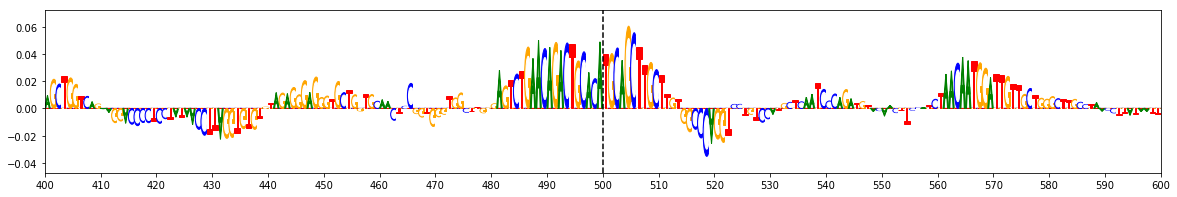

Effect Allele : G   ||   Explain Score : 0.7355   ||   Center / 200bp : 0.4138
Effect Sequence : AGACTGCACGTGCAGCTTGC


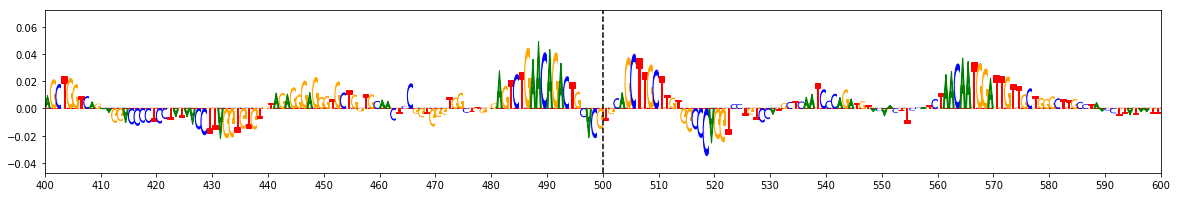

Allele Ratio : 0.6276   ||   Allele Difference : -0.5096  ||  ISM Score : -0.8074  ||  deltaSVM Score : -4.4918


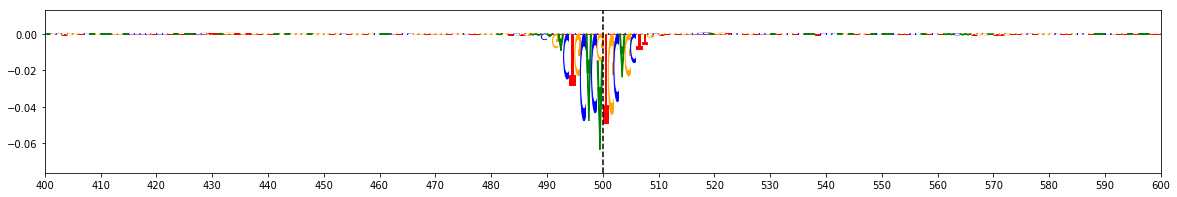


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1468241   ||    chr17 : 46118786 - 46118787   ||    Locus: 267   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.69E-22
Parkinsons_Pankratz_2012 	  4.48E-10

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 1.3787   ||   Center / 200bp : 0.7614
Noneffect Sequence : ACAACCAATAGTCAGTGCAC


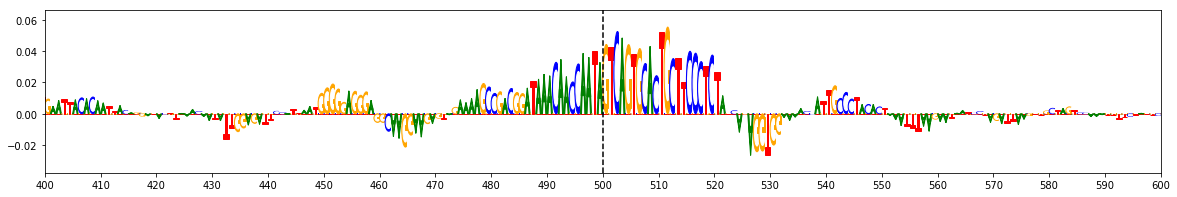

Effect Allele : G   ||   Explain Score : 1.2574   ||   Center / 200bp : 0.7441
Effect Sequence : ACAACCAATGGTCAGTGCAC


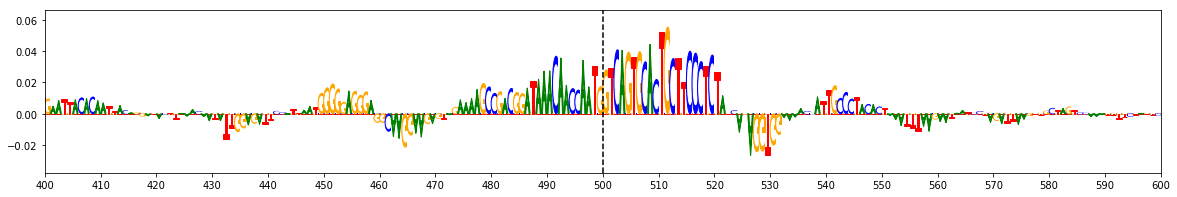

Allele Ratio : 0.912   ||   Allele Difference : -0.1213  ||  ISM Score : -0.1873  ||  deltaSVM Score : -1.08


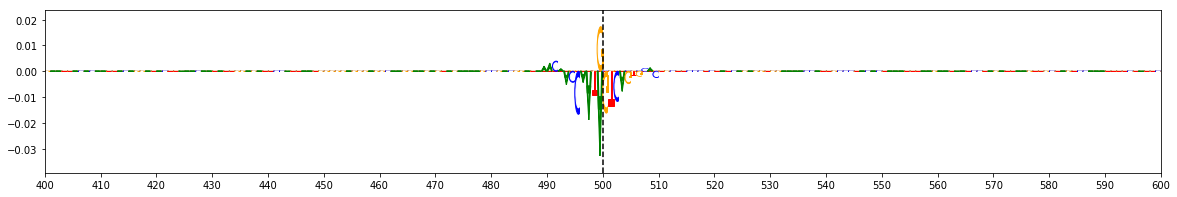


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [6]:
for idx in neg_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Find Non-Effect Alleles that Improve Accessibility <a name='noneffect_table' />

In [7]:
pos_snps = snps.loc[snps['allele_ratio'] > 1]
pos_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect         ref  \
390   chr2   95074354   95074355    rs7585473      T         G           T   
73   chr15   64453059   64453060  rs143560707      G         C           C   
223  chr17   45947293   45947294   rs62062786      G         C           G   
456   chr4     959909     959910    rs4690326      C         A           A   
138  chr17   45825577   45825578    rs1912151      T         C           C   
286  chr17   46771150   46771151     rs199523      C         A           C   
282  chr17   46213482   46213483   rs76475191      T         A           T   
283  chr17   46213483   46213484   rs78826239      T         A           T   
461   chr4     987143     987144   rs10902762      G         A           G   
0     chr1   39878995   39878996    rs7527412      A         G           G   
135  chr17   45825432   45825433    rs3885075      G         A           A   
538   chr8   22599691   22599692     rs755934      T         G           T   
9     chr1  226737182  226737183  rs147889095      I         D  ACTGCCGCTG   
249  chr17   46013337   46013338   rs62062266      G         A           A   
141  chr17   45825722   45825723   rs41280118      T         C           C   
539   chr8   22604860   22604861    rs3735901      T         C           T   
351  chr19   44912841   44912842   rs72654437      A         G           G   
537   chr8   11845910   11845911    rs1736082      T         C           C   
219  chr17   45942947   45942948   rs62062772      T         C           C   
281  chr17   46213392   46213393    rs2668662      T         C           T   
187  chr17   45894775   45894776   rs11575896      G         A           G   
56   chr12  122842050  122842051   rs10847864      T         G           G   
519   chr6   27772886   27772887    rs9468223      T         C           C   
147  chr17   45826181   45826182   rs62057150      T         C           C   
34   chr11   65889092   65889093    rs2231884      T         C           C   
89   chr16   31106091   31106092    rs2032915      T         C           C   
419   chr2  127118083  127118084   rs10929007      A         G           A   
272  chr17   46122666   46122667   rs62061858      T         C           T   
137  chr17   45825494   45825495   rs34283254      C         A           C   
57   chr13   97212766   97212767    rs4771268      T         C           T   
..     ...        ...        ...          ...    ...       ...         ...   
358  chr19   44915228   44915229   rs12691088      A         G           G   
466   chr4   89709523   89709524     rs356177    NAN       NAN           C   
514   chr5  103224361  103224362     rs152137      T         C           C   
296  chr17   75034714   75034715   rs11870474      A         C           C   
359  chr19   44925201   44925202    rs4803772      T         C           C   
11   chr10   15515115   15515116     rs878321      G         A           G   
117  chr17   44220262   44220263  rs113844752      C         A           C   
82   chr16   30958235   30958236   rs62055866      G         C           G   
24   chr11   47354896   47354897    rs1057233      A         G           G   
549   chr8   27636848   27636849  rs138529507      C         T           T   
262  chr17   46101517   46101518   rs62061810      G         A           G   
160  chr17   45849620   45849621    rs8068916      T         G           T   
284  chr17   46213543   46213544   rs79861768      G         A           A   
220  chr17   45943178   45943179   rs62062773      G         A           A   
447   chr3   52597590   52597591  rs143667157      C         A           A   
155  chr17   45848689   45848690   rs62054818      C         A           A   
230  chr17   45976622   45976623   rs62063778      G         A           G   
545   chr8   27610303   27610304    rs2070926      C         G           C   
21   chr11   47255123   47255124   rs11039149      A         G           A   
109  chr17    4902141    4902

## Visualize Top Non-Effect Alleles <a name='noneffect_viz' />

RSID: rs7585473   ||    chr2 : 95074354 - 95074355   ||    Locus: 390   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  3.67E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.7511   ||  Center / 200bp: 0.4444
Effect Sequence: TGACCCCATTGTCCTTCCCT


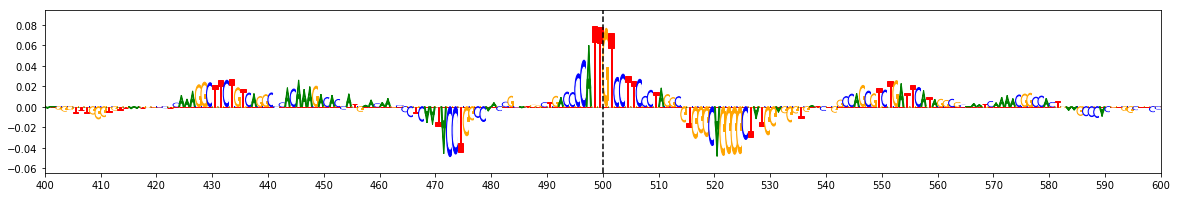

Noneffect Allele: G   ||  Explain Score: 0.1143   ||  Center / 200bp: 0.1086
Noneffect Sequence: TGACCCCATGGTCCTTCCCT


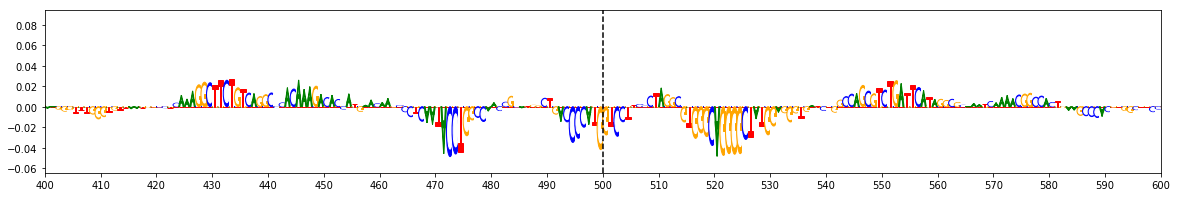

Allele Ratio : 6.5686   ||   Allele Difference : 0.9389  ||  ISM Score : 1.4652  ||  deltaSVM Score : 8.389


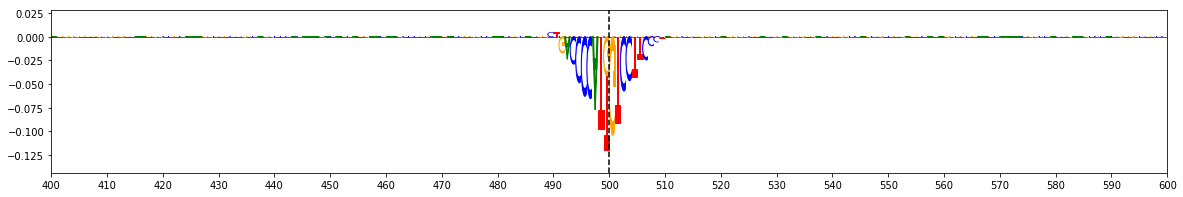


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs143560707   ||    chr15 : 64453059 - 64453060   ||    Locus: 73   ||    IDR Peak: True

GWAS:
Alzheimers_Lambert_2013 	  3.03E-06

Coloc:  True

Effect Allele: G   ||  Explain Score: 1.084   ||  Center / 200bp: 0.7636
Effect Sequence: TGGCACACAGCTGTAGTCCC


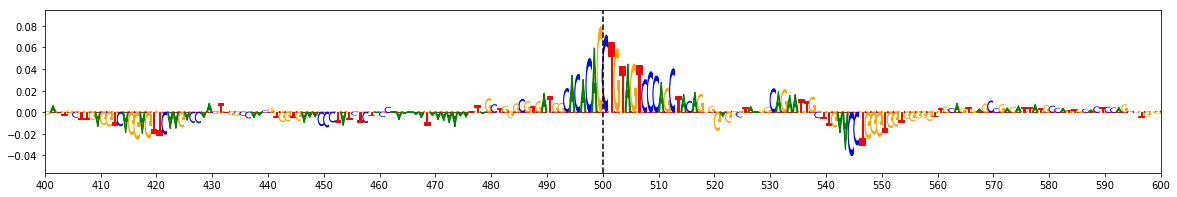

Noneffect Allele: C   ||  Explain Score: 0.3126   ||  Center / 200bp: 0.4826
Noneffect Sequence: TGGCACACACCTGTAGTCCC


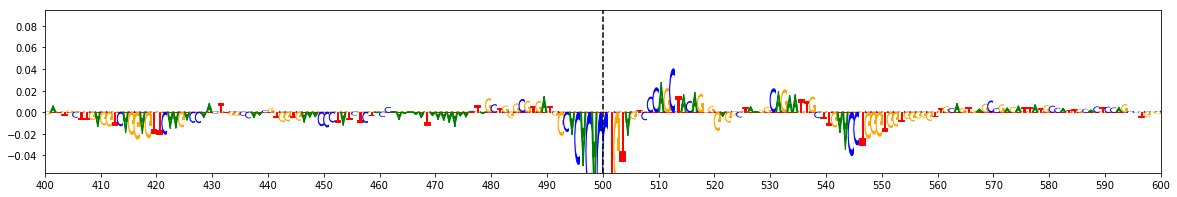

Allele Ratio : 3.4676   ||   Allele Difference : 1.5591  ||  ISM Score : 2.4461  ||  deltaSVM Score : 14.0788


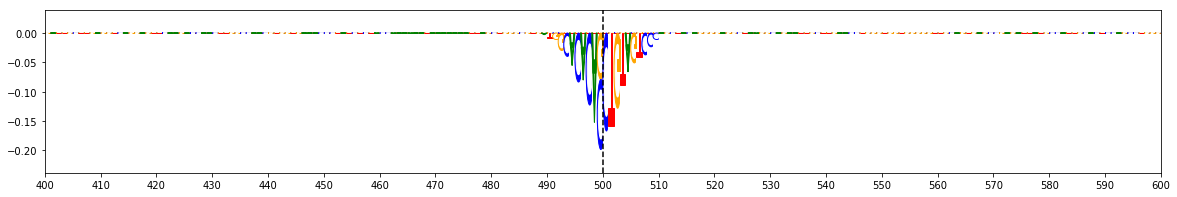


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62062786   ||    chr17 : 45947293 - 45947294   ||    Locus: 223   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  4.53E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.3534   ||  Center / 200bp: 0.3418
Effect Sequence: TGGGGACCAGCTGCCACAGA


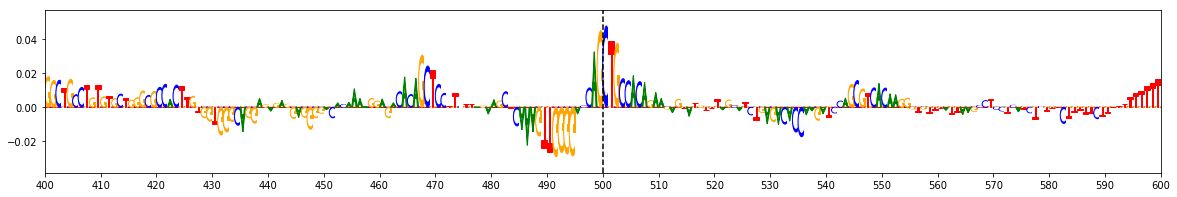

Noneffect Allele: C   ||  Explain Score: 0.0477   ||  Center / 200bp: 0.0655
Noneffect Sequence: TGGGGACCACCTGCCACAGA


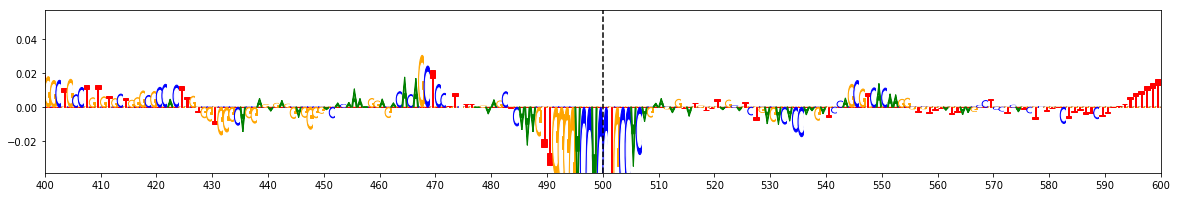

Allele Ratio : 7.4096   ||   Allele Difference : 1.2749  ||  ISM Score : 2.078  ||  deltaSVM Score : 11.8834


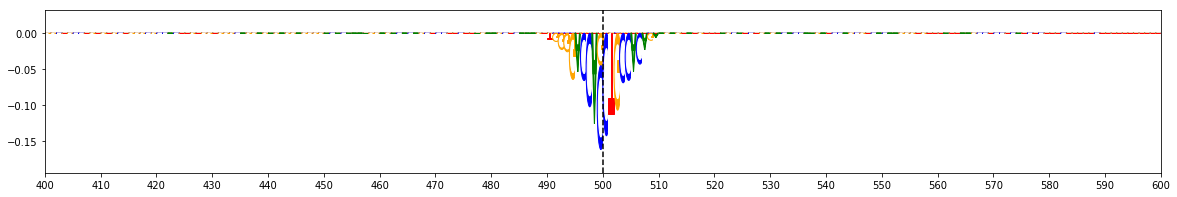


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs4690326   ||    chr4 : 959909 - 959910   ||    Locus: 456   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.53E-10

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.5271   ||  Center / 200bp: 0.3858
Effect Sequence: CTCCTCCCCCAGCAGAGGCA


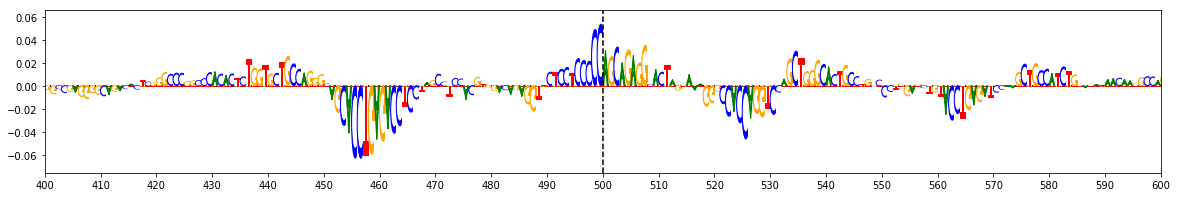

Noneffect Allele: A   ||  Explain Score: 0.1107   ||  Center / 200bp: 0.1164
Noneffect Sequence: CTCCTCCCCAAGCAGAGGCA


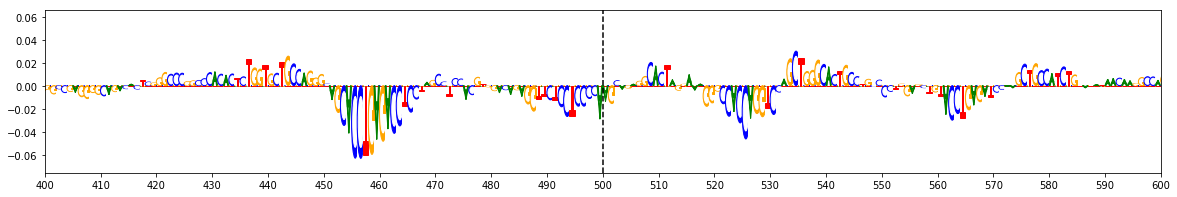

Allele Ratio : 4.7602   ||   Allele Difference : 0.6408  ||  ISM Score : 1.015  ||  deltaSVM Score : 5.9325


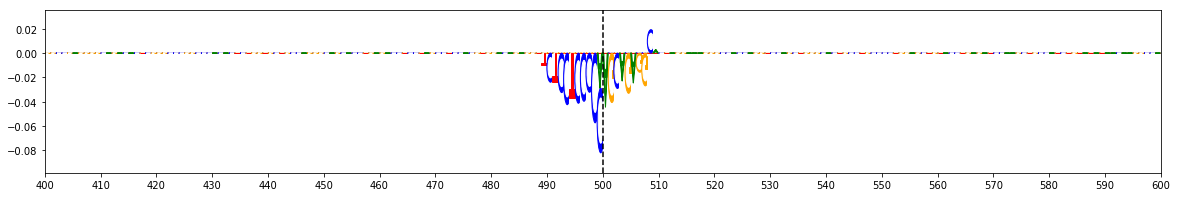


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1912151   ||    chr17 : 45825577 - 45825578   ||    Locus: 138   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.33E-22
Parkinsons_Pankratz_2012 	  1.22E-09

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.3094   ||  Center / 200bp: 0.2676
Effect Sequence: GGTTCACTGTTCACCGTGTG


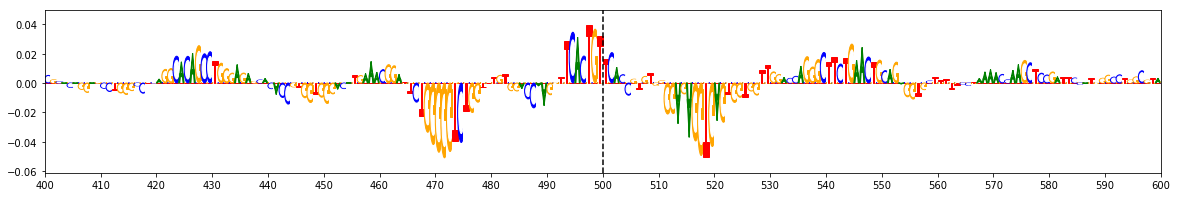

Noneffect Allele: C   ||  Explain Score: 0.0591   ||  Center / 200bp: 0.0653
Noneffect Sequence: GGTTCACTGCTCACCGTGTG


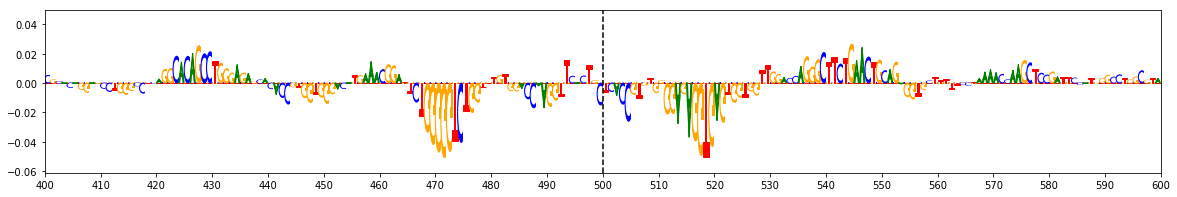

Allele Ratio : 5.2375   ||   Allele Difference : 0.3686  ||  ISM Score : 0.5799  ||  deltaSVM Score : 3.358


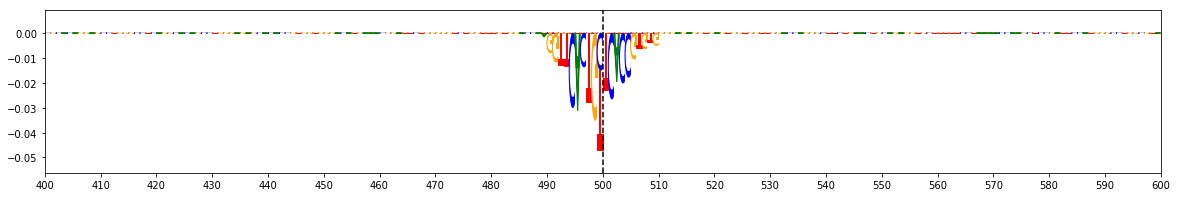


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs199523   ||    chr17 : 46771150 - 46771151   ||    Locus: 286   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  9.49E-14

Coloc:  True

Effect Allele: C   ||  Explain Score: 1.3542   ||  Center / 200bp: 0.4976
Effect Sequence: GCCCTCCTGCGCCACCTACA


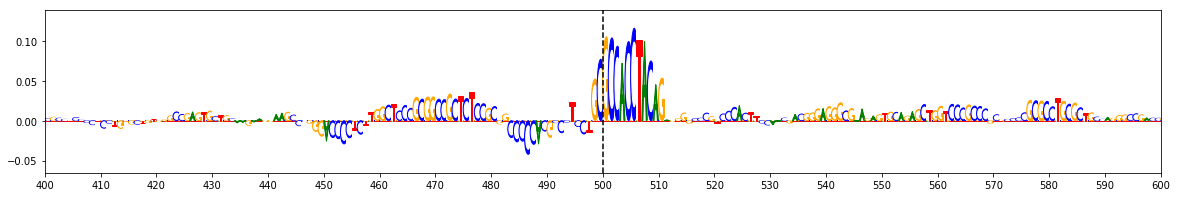

Noneffect Allele: A   ||  Explain Score: 0.6214   ||  Center / 200bp: 0.312
Noneffect Sequence: GCCCTCCTGAGCCACCTACA


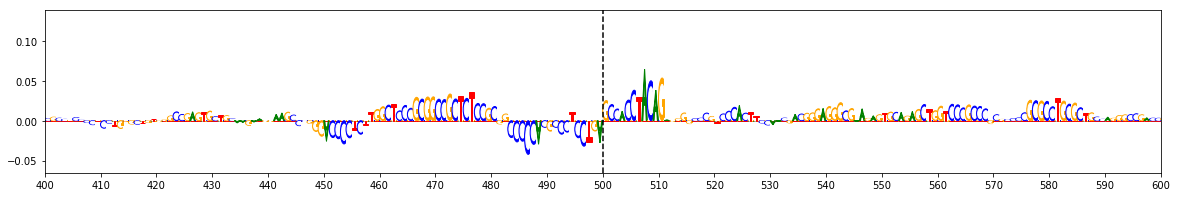

Allele Ratio : 2.1794   ||   Allele Difference : 0.8229  ||  ISM Score : 1.3066  ||  deltaSVM Score : 7.5222


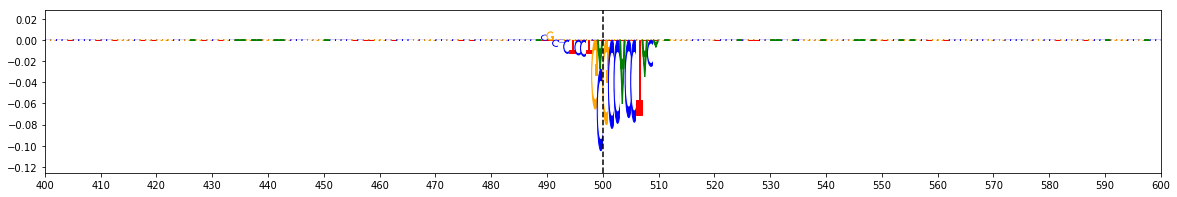


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs76475191   ||    chr17 : 46213482 - 46213483   ||    Locus: 282   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.10E-18

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.4319   ||  Center / 200bp: 0.6029
Effect Sequence: TTTTTTTTTTTTTTTTAGTA


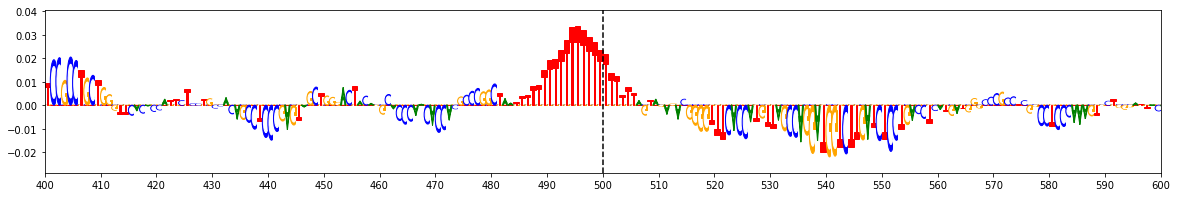

Noneffect Allele: A   ||  Explain Score: 0.2414   ||  Center / 200bp: 0.39
Noneffect Sequence: TTTTTTTTTATTTTTTAGTA


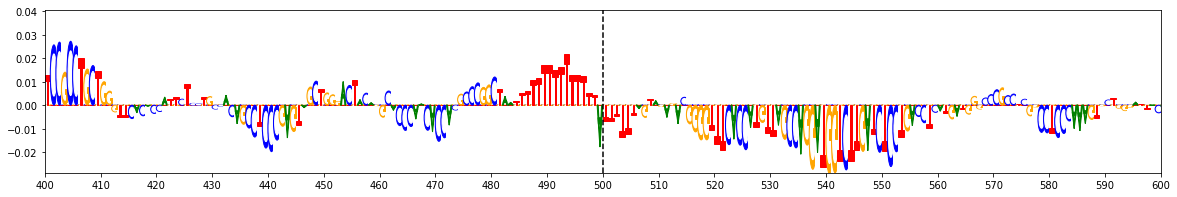

Allele Ratio : 1.7889   ||   Allele Difference : 0.2969  ||  ISM Score : 0.3283  ||  deltaSVM Score : 11.4723


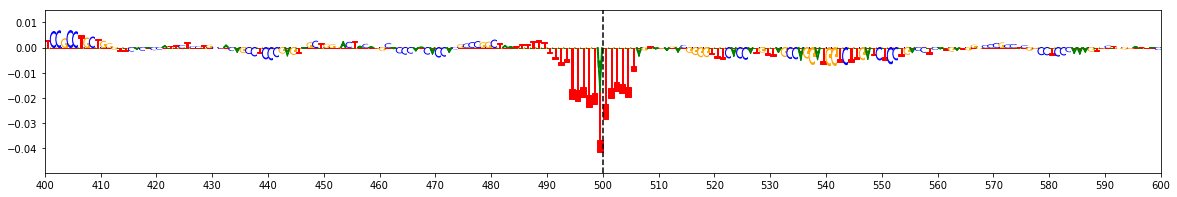


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs78826239   ||    chr17 : 46213483 - 46213484   ||    Locus: 283   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.10E-18

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.4265   ||  Center / 200bp: 0.6035
Effect Sequence: TTTTTTTTTTTTTTTAGTAG


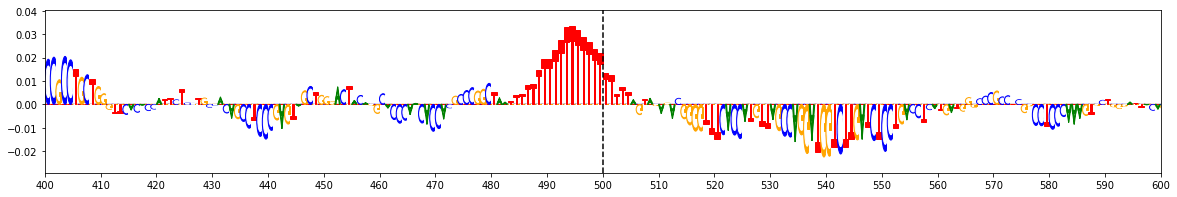

Noneffect Allele: A   ||  Explain Score: 0.2739   ||  Center / 200bp: 0.4335
Noneffect Sequence: TTTTTTTTTATTTTTAGTAG


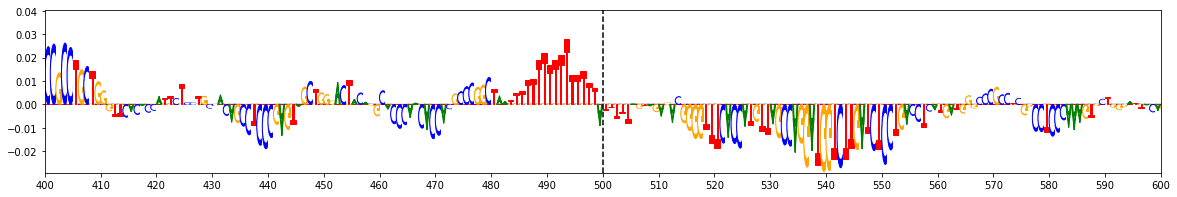

Allele Ratio : 1.557   ||   Allele Difference : 0.2209  ||  ISM Score : 0.242  ||  deltaSVM Score : 9.502


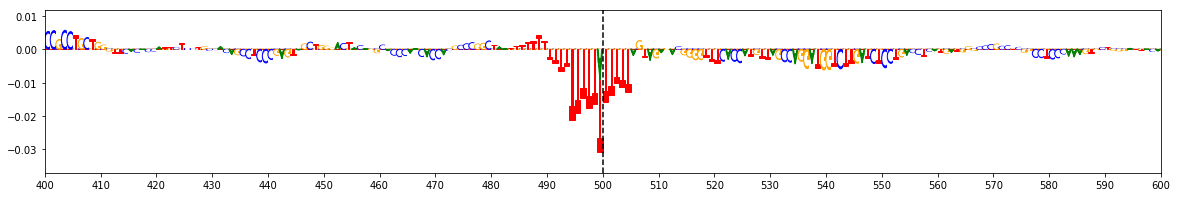


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10902762   ||    chr4 : 987143 - 987144   ||    Locus: 461   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.90E-11

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.3428   ||  Center / 200bp: 0.4092
Effect Sequence: CCTGGCCGCGCCCCCGGTGG


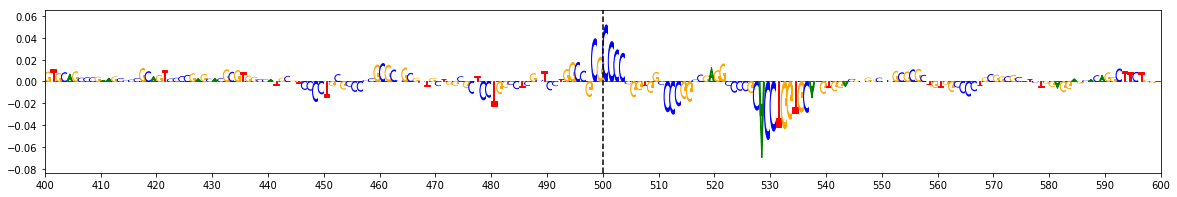

Noneffect Allele: A   ||  Explain Score: 0.1505   ||  Center / 200bp: 0.2305
Noneffect Sequence: CCTGGCCGCACCCCCGGTGG


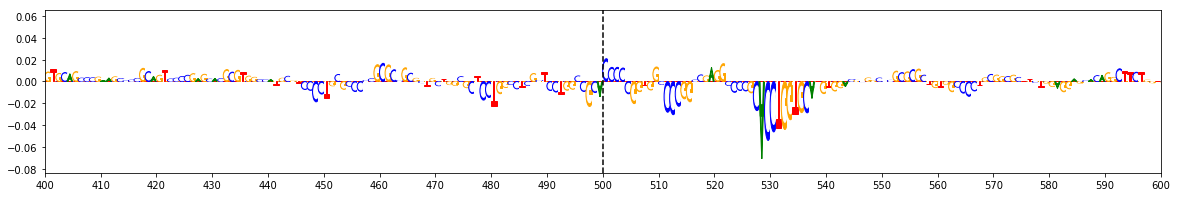

Allele Ratio : 2.2768   ||   Allele Difference : 0.2863  ||  ISM Score : 0.4661  ||  deltaSVM Score : 2.7733


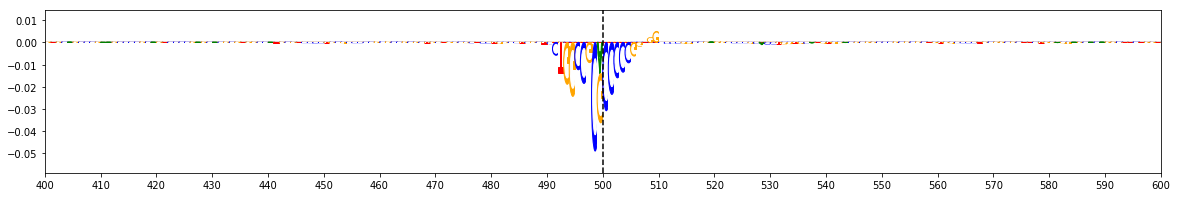


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7527412   ||    chr1 : 39878995 - 39878996   ||    Locus: 0   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  1.35E-05

Coloc:  True

Effect Allele: A   ||  Explain Score: 0.6483   ||  Center / 200bp: 0.7142
Effect Sequence: TGGCCTGGCACAGTGGCTCA


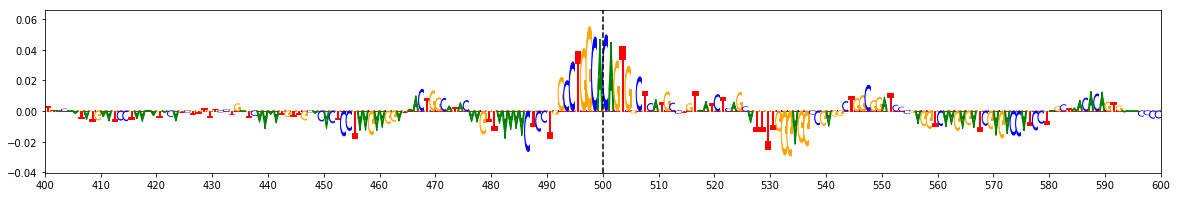

Noneffect Allele: G   ||  Explain Score: 0.5104   ||  Center / 200bp: 0.6631
Noneffect Sequence: TGGCCTGGCGCAGTGGCTCA


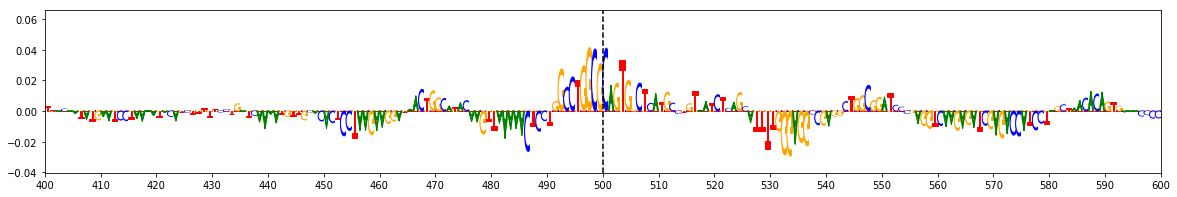

Allele Ratio : 1.2702   ||   Allele Difference : 0.1248  ||  ISM Score : 0.195  ||  deltaSVM Score : 1.0833


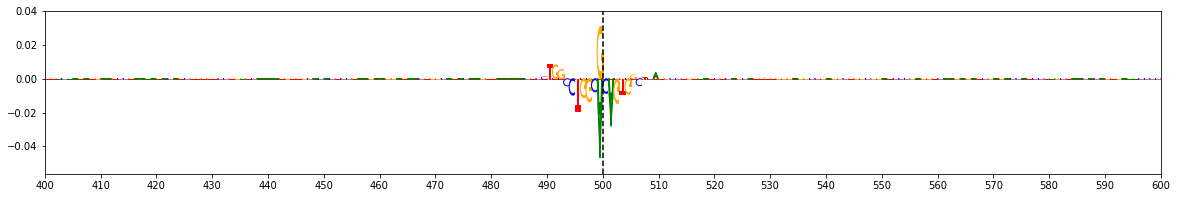


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3885075   ||    chr17 : 45825432 - 45825433   ||    Locus: 135   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.34E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.7614   ||  Center / 200bp: 0.4928
Effect Sequence: CCCCCACCCGCCCAACACTT


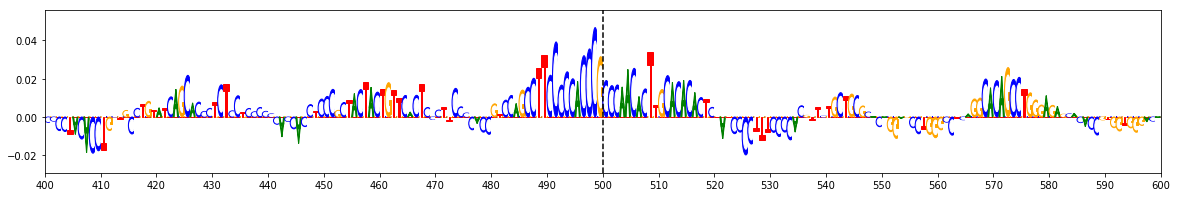

Noneffect Allele: A   ||  Explain Score: 0.4215   ||  Center / 200bp: 0.351
Noneffect Sequence: CCCCCACCCACCCAACACTT


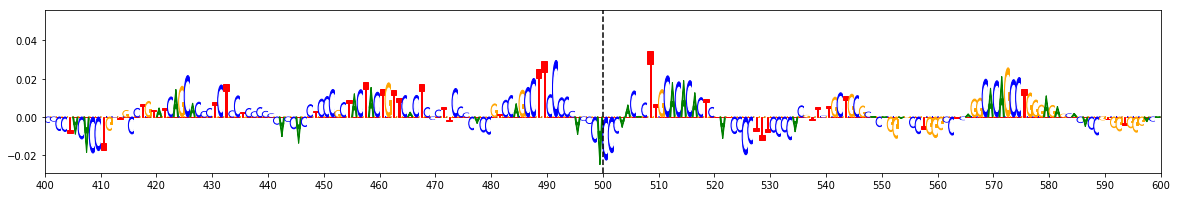

Allele Ratio : 1.8064   ||   Allele Difference : 0.447  ||  ISM Score : 0.7156  ||  deltaSVM Score : 4.0828


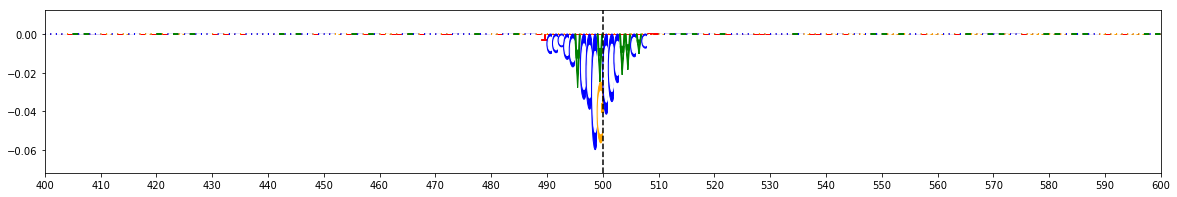


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs755934   ||    chr8 : 22599691 - 22599692   ||    Locus: 538   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  5.11E-02
Nalls_23andMe 		  5.11E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.8824   ||  Center / 200bp: 0.5145
Effect Sequence: GCGGCTGCATTGGCCGGGGC


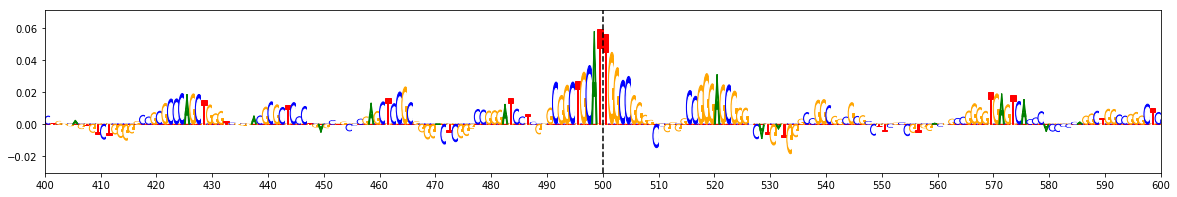

Noneffect Allele: G   ||  Explain Score: 0.5425   ||  Center / 200bp: 0.396
Noneffect Sequence: GCGGCTGCAGTGGCCGGGGC


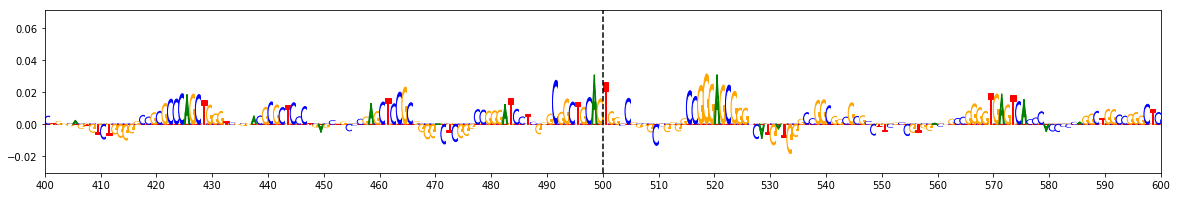

Allele Ratio : 1.6264   ||   Allele Difference : 0.3464  ||  ISM Score : 0.5528  ||  deltaSVM Score : 3.4364


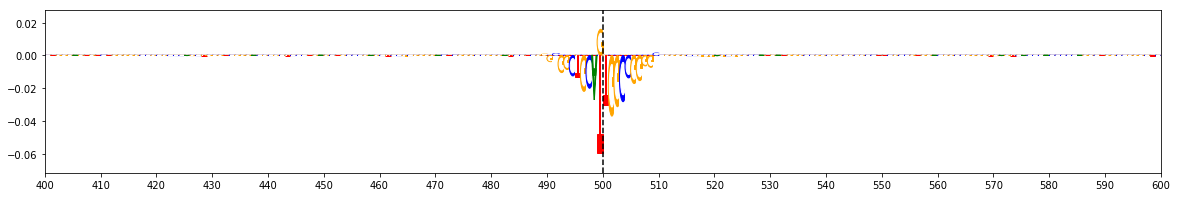


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs147889095   ||    chr1 : 226737182 - 226737183   ||    Locus: 9   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.77E-05
Nalls_23andMe 		  1.77E-05

Coloc:  False

Effect Allele: I   ||  Explain Score: 0.8795   ||  Center / 200bp: 0.6236
Effect Sequence: ACTGCCGCTGCCACTGCCGC


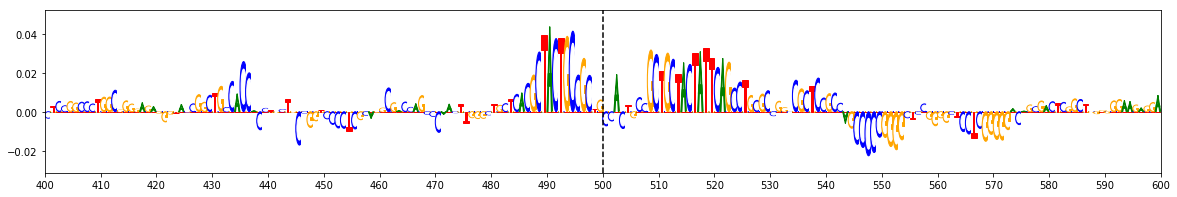

Noneffect Allele: D   ||  Explain Score: 0.6752   ||  Center / 200bp: 0.5172
Noneffect Sequence: ACTGCCGCTGCTGCCGCTGC


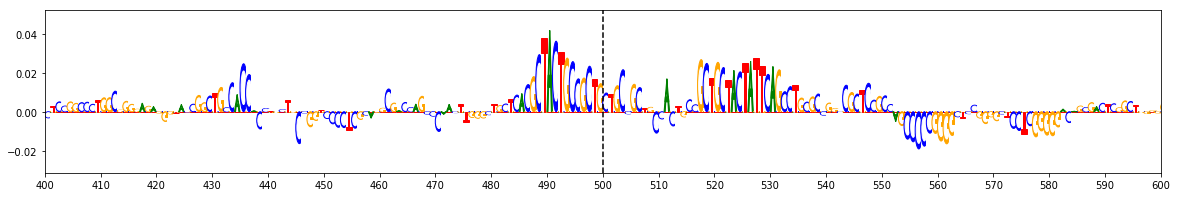

Allele Ratio : 1.3027   ||   Allele Difference : 0.2056  ||  ISM Score : 0.3604  ||  deltaSVM Score : 2.2306


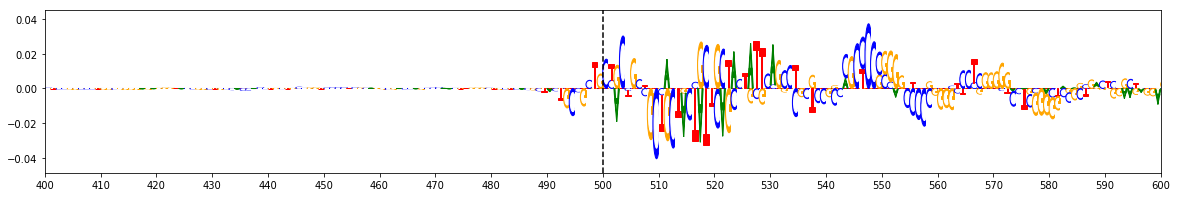


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62062266   ||    chr17 : 46013337 - 46013338   ||    Locus: 249   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.09E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.7639   ||  Center / 200bp: 0.5449
Effect Sequence: CTGCCTCCAGGGGACCTGTC


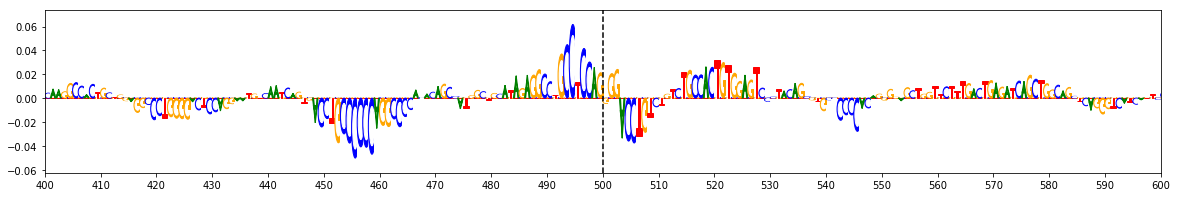

Noneffect Allele: A   ||  Explain Score: 0.5154   ||  Center / 200bp: 0.4457
Noneffect Sequence: CTGCCTCCAAGGGACCTGTC


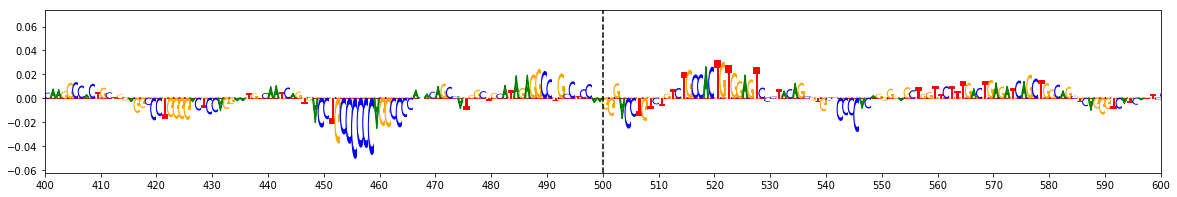

Allele Ratio : 1.4821   ||   Allele Difference : 0.19  ||  ISM Score : 0.3078  ||  deltaSVM Score : 1.7935


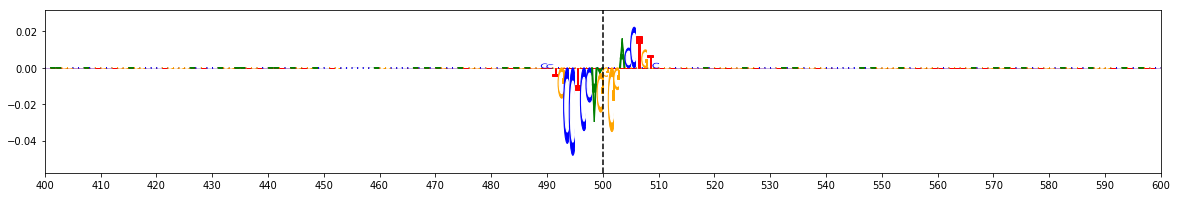


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs41280118   ||    chr17 : 45825722 - 45825723   ||    Locus: 141   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.33E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.702   ||  Center / 200bp: 0.4839
Effect Sequence: GCTCCTCTGTGTGCTGTTGC


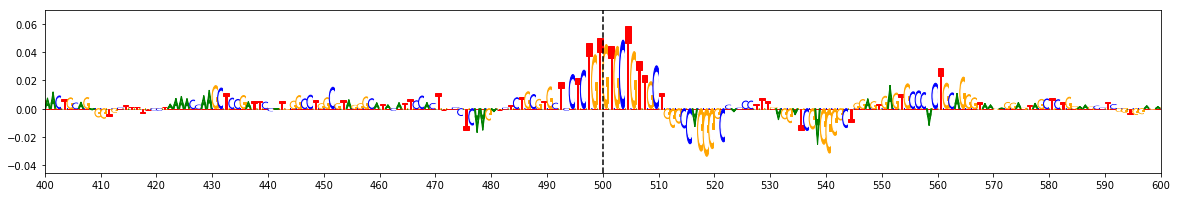

Noneffect Allele: C   ||  Explain Score: 0.4245   ||  Center / 200bp: 0.3653
Noneffect Sequence: GCTCCTCTGCGTGCTGTTGC


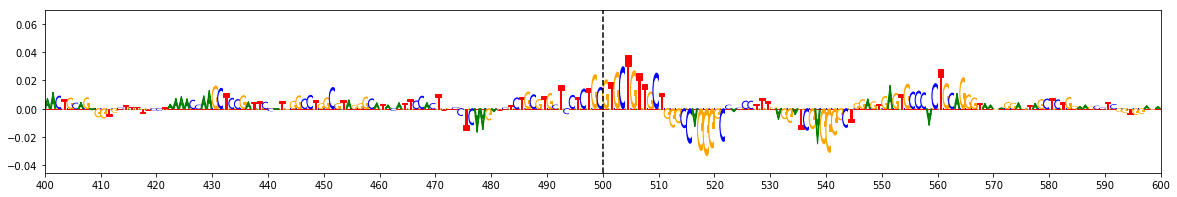

Allele Ratio : 1.6534   ||   Allele Difference : 0.2759  ||  ISM Score : 0.4374  ||  deltaSVM Score : 2.4576


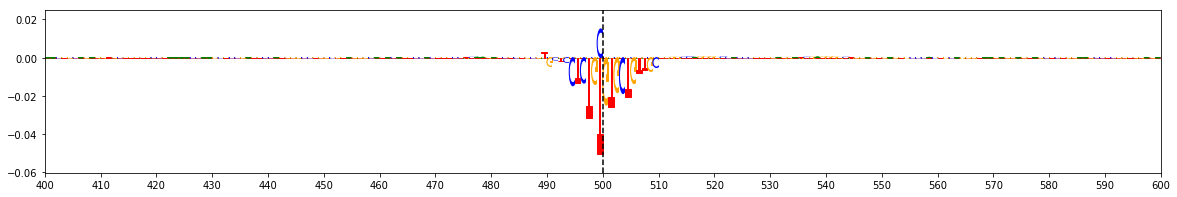


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3735901   ||    chr8 : 22604860 - 22604861   ||    Locus: 539   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  5.08E-02
Nalls_23andMe 		  5.08E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.2659   ||  Center / 200bp: 0.1596
Effect Sequence: GGGGCCCCCTGCCGCCCCTC


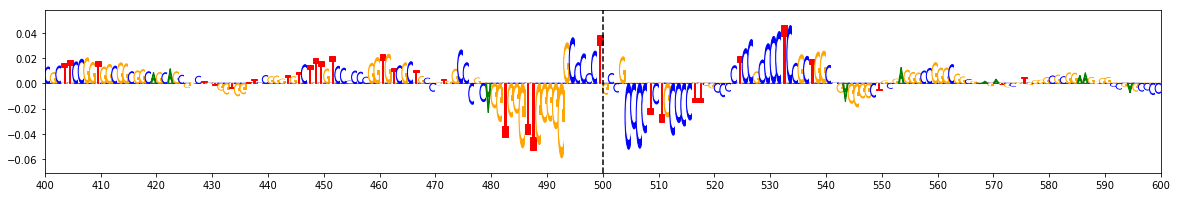

Noneffect Allele: C   ||  Explain Score: 0.0549   ||  Center / 200bp: 0.0388
Noneffect Sequence: GGGGCCCCCCGCCGCCCCTC


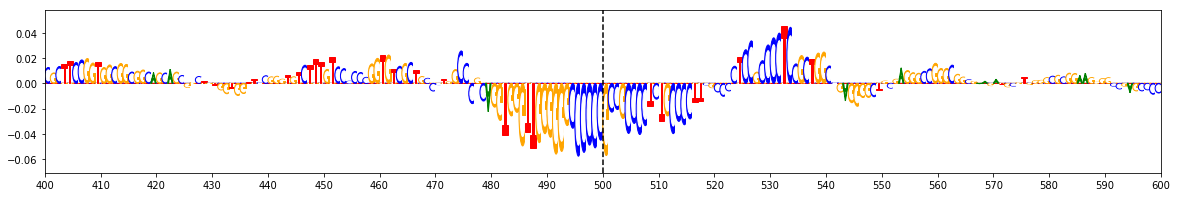

Allele Ratio : 4.8469   ||   Allele Difference : 0.6257  ||  ISM Score : 0.9756  ||  deltaSVM Score : 6.5385


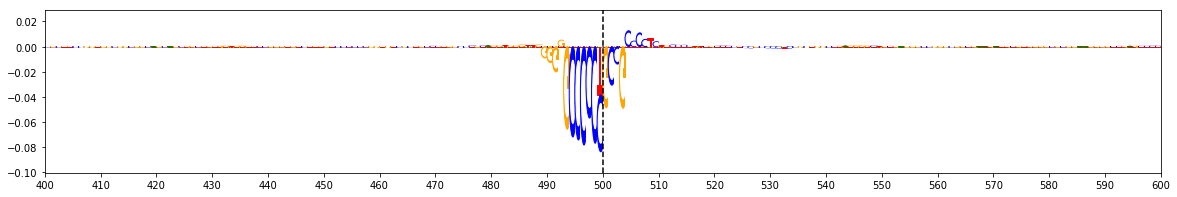


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs72654437   ||    chr19 : 44912841 - 44912842   ||    Locus: 351   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  2.28E-09

Coloc:  True

Effect Allele: A   ||  Explain Score: 1.0154   ||  Center / 200bp: 0.741
Effect Sequence: ATTCTTGTGAGGTCTGGGAA


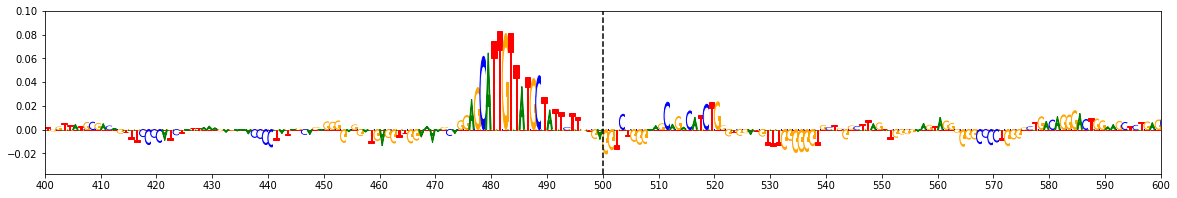

Noneffect Allele: G   ||  Explain Score: 0.9782   ||  Center / 200bp: 0.7338
Noneffect Sequence: ATTCTTGTGGGGTCTGGGAA


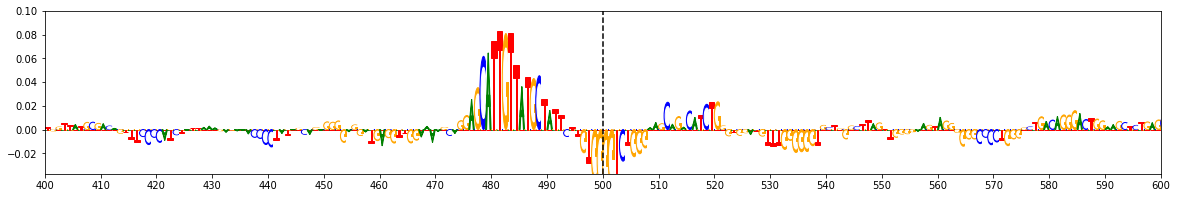

Allele Ratio : 1.0379   ||   Allele Difference : 0.3339  ||  ISM Score : 0.5215  ||  deltaSVM Score : 2.9717


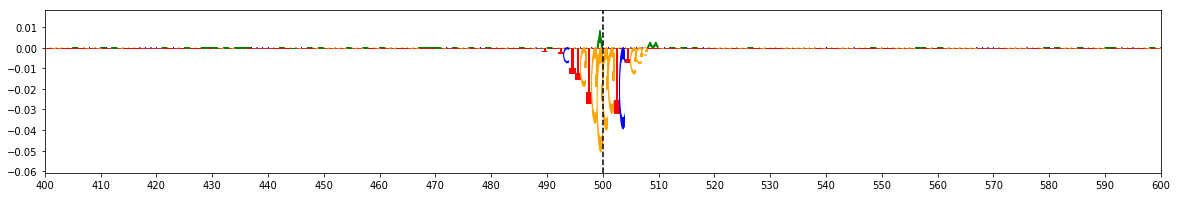


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1736082   ||    chr8 : 11845910 - 11845911   ||    Locus: 537   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.28E-04

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.8267   ||  Center / 200bp: 0.6039
Effect Sequence: AACCTGCTGTTCCACCAGGA


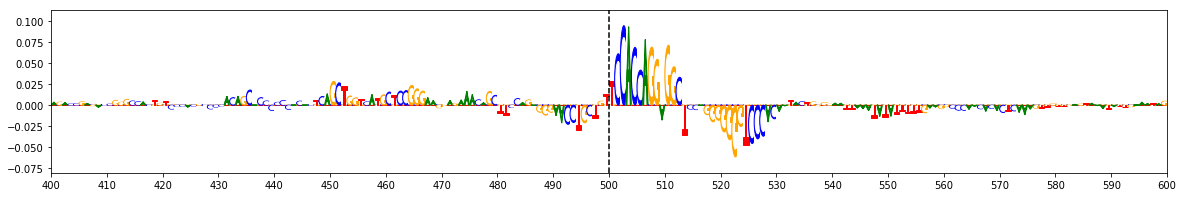

Noneffect Allele: C   ||  Explain Score: 0.6653   ||  Center / 200bp: 0.5511
Noneffect Sequence: AACCTGCTGCTCCACCAGGA


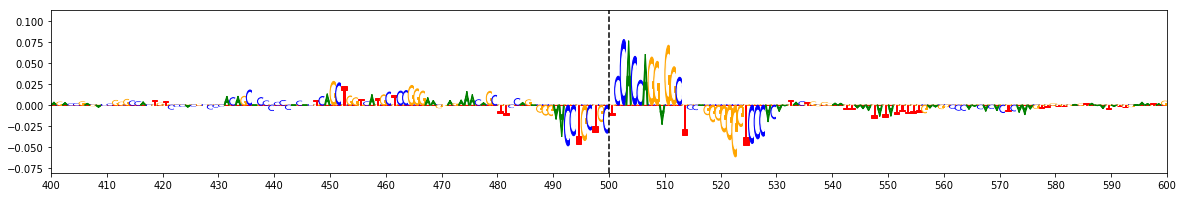

Allele Ratio : 1.2426   ||   Allele Difference : 0.3683  ||  ISM Score : 0.5732  ||  deltaSVM Score : 3.3541


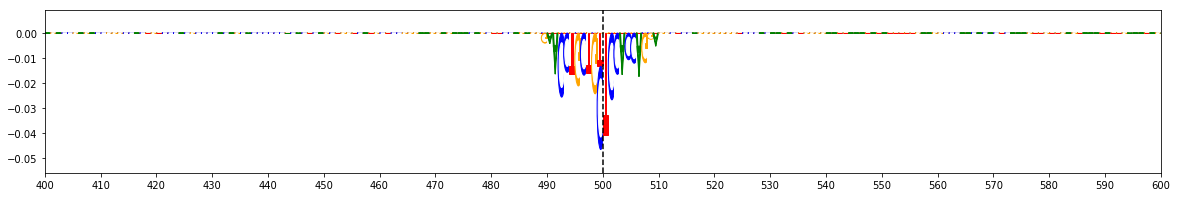


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62062772   ||    chr17 : 45942947 - 45942948   ||    Locus: 219   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.65E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.3782   ||  Center / 200bp: 0.6684
Effect Sequence: GACTCCCTGTACTGCGCTGT


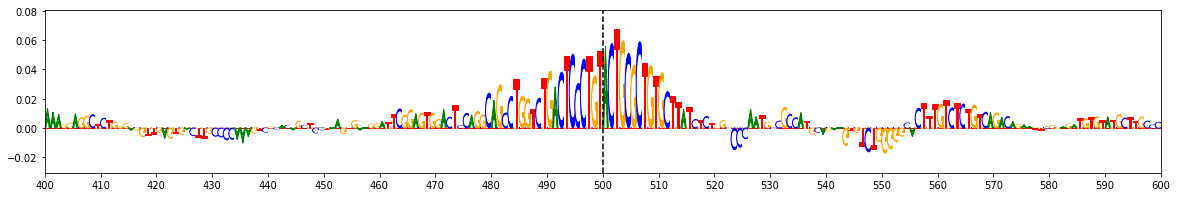

Noneffect Allele: C   ||  Explain Score: 1.2298   ||  Center / 200bp: 0.6437
Noneffect Sequence: GACTCCCTGCACTGCGCTGT


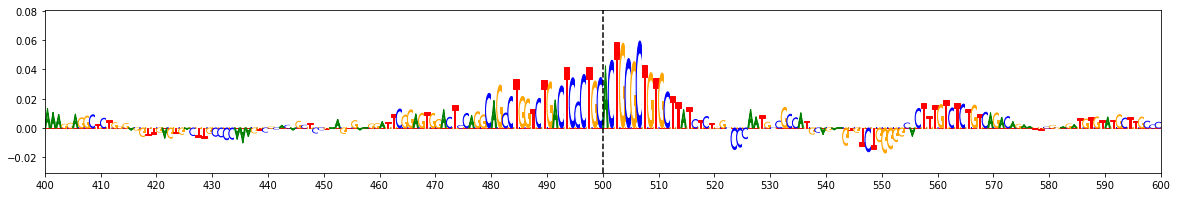

Allele Ratio : 1.1207   ||   Allele Difference : 0.1483  ||  ISM Score : 0.2383  ||  deltaSVM Score : 1.3249


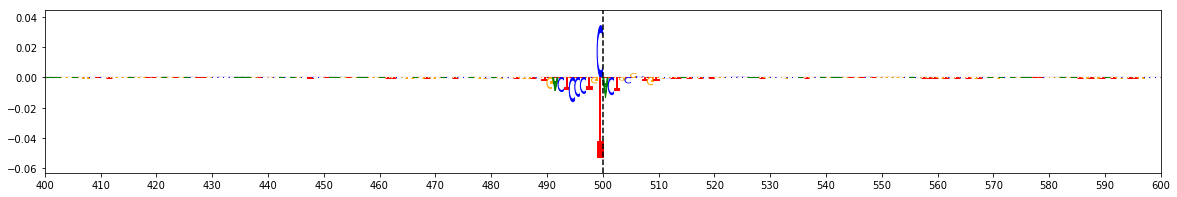


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2668662   ||    chr17 : 46213392 - 46213393   ||    Locus: 281   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  7.45E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.2384   ||  Center / 200bp: 0.6058
Effect Sequence: TCCGCCTGCTGGGTTCACAC


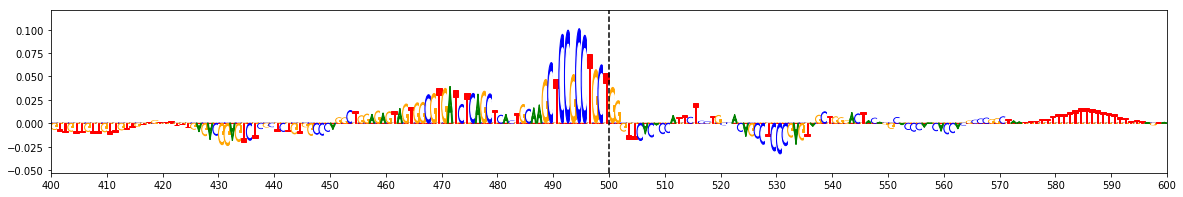

Noneffect Allele: C   ||  Explain Score: 1.0126   ||  Center / 200bp: 0.5567
Noneffect Sequence: TCCGCCTGCCGGGTTCACAC


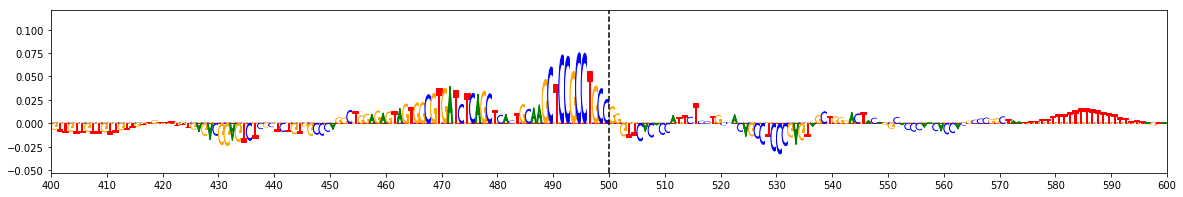

Allele Ratio : 1.223   ||   Allele Difference : 0.2229  ||  ISM Score : 0.4048  ||  deltaSVM Score : 2.3977


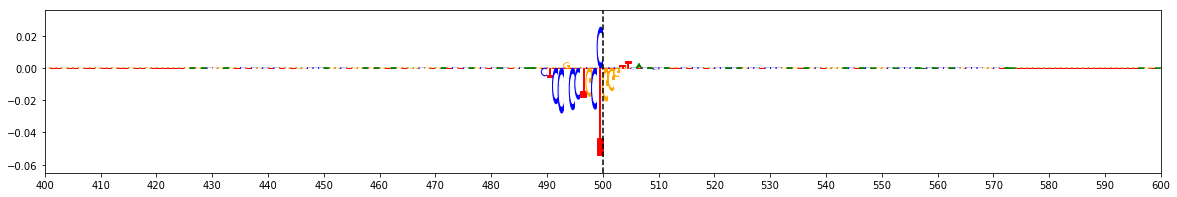


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [8]:
for idx in pos_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()